In [522]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt

import scipy.stats as stats
from functools import reduce

%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use("seaborn")


import sqlalchemy as sa
from sqlalchemy.engine.url import URL
from sqlalchemy.orm import Session
%reload_ext sql
%config SqlMagic.displaylimit = 25

import pygsheets
gc = pygsheets.authorize(service_account_file='address-on-sheet.json')

import pygsheets
gc = pygsheets.authorize(service_account_file='address-on-sheet.json')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\ibrad\AppData\Roaming\Python\Python311\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['f', 'norm']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +
C:\Users\ibrad\AppData\Local\Temp\ipykernel_25104\3611782494.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


Open By Key (Using a googlesheet link)

In [ ]:
sh = gc.open_by_key('1w85xdKvJ86Hc0Hn53M_3tezWQfRziCt0Kjt-Mn04mRM')

Appending the data in one Datafrome

In [ ]:
recon_list = []
tabs = ['22 Mar 2021 - 14 Mar 2022','21 Mar 2022 - 27 Jun 2022','4 Jul 2022 - 12 Sep 2022','19 Sep 2022 - 31 Oct 2022']
for tab in tabs:
    recon_records = sh.worksheet_by_title(tab).get_all_records()
    recon_df = pd.DataFrame.from_records(recon_records)
    recon_df.replace('', np.nan, inplace=True)
    recon_df['Week'] = recon_df['Week'].str.split("/").apply(lambda x: str(x[2]) + "-" + str(x[1]) + "-" + str(x[0]))
    recon_list.append(recon_df)
recondata_df = pd.concat(recon_list)
recondata_df

Make a copy of recondata_df

In [ ]:
recondata = recondata_df.copy()
recondata.info()

Look into the Data

In [ ]:
recondata.info()

Drop Supply Hours and Cummulative Outstanding

In [ ]:
recondata = recondata.drop(columns=['Supply Hours', 'Cumm. Outstanding'])

Turn recondata into an Object 

In [ ]:
recondata['UUID'] = recondata['UUID'].astype(object)

Cleaning the data and Turning all Columns to be used for calculation into 'float'

In [ ]:
recondata['Net Earnings'].replace(",", '' ,regex=True,inplace=True)
recondata['Amount Due'].replace(",", '' ,regex=True,inplace=True)
recondata['Outstanding'].replace(",", '' ,regex=True,inplace=True)
recondata['Net Earnings'] = recondata['Net Earnings'].astype(float)
recondata['Amount Due'] = recondata['Amount Due'].astype(float)
recondata['Outstanding'] = recondata['Outstanding'].astype(float)
#recondata['Cumm. Outstanding'] = recondata['Cumm. Outstanding'].astype(float)
#recondata['Working days'] = recondata['Working days'].astype(float)


Calculate Gross Earnings

In [ ]:
recondata['Gross Earnings'] = (recondata['Net Earnings']/0.75).round(2)
#recondata['count'] = (recondata['count']).max()
recondata

Create the column Effective days and Working days

In [ ]:
recondata['Effective days'] = 1
recondata['Working days'] = ""

Assign '1' to Trips greater than 0 and '0' to Trips less than or '=' 0

In [ ]:
recondata.loc[(recondata['Trips']>0),'Working days']=1
recondata.loc[(recondata['Trips']<=0),'Working days']=0


Clean data:
1. Remove ','
2. Convert 'Net Earnings', 'Amount Due', 'Outstanding', 'Working days' to float

In [ ]:
recondata['Net Earnings'].replace(",", '' ,regex=True,inplace=True)
recondata['Amount Due'].replace(",", '' ,regex=True,inplace=True)
recondata['Outstanding'].replace(",", '' ,regex=True,inplace=True)
recondata['Net Earnings'] = recondata['Net Earnings'].astype(float)
recondata['Amount Due'] = recondata['Amount Due'].astype(float)
recondata['Outstanding'] = recondata['Outstanding'].astype(float)
#recondata['Cumm. Outstanding'] = recondata['Cumm. Outstanding'].astype(float)
recondata['Working days'] = recondata['Working days'].astype(float)



recondata['Gross Earnings'] = (recondata['Net Earnings']/0.75).round(2)
#recondata['count'] = (recondata['count']).max()
recondata

Create a pivot table using 'UUID','DRN','Week' to summarize the data

In [ ]:
loandata = recondata.pivot_table(index=['UUID','DRN','Week'],aggfunc='sum').reset_index()
loandata.drop(labels=['Net Earnings'],axis=1, inplace=True)
loandata.sort_values(by='Week') 

loandata


In [ ]:
# Since the data is calculating 7 effectives we convert it to '6' for easy calculation

loandata.loc[(loandata['Effective days']>6),'Effective days']=6
loandata

In [ ]:
loandata_df = loandata.copy() #create a copy!
loandata_df
 
loandata
#Question: Why is it that when I run some codes it gets to a point when it returns error even though it is been executed

In [ ]:
supply_df = pd.read_csv("C:/Users/ibrad/Downloads/API on Sheet - Ghana/Ghana Supply Hours.csv")
supply = supply_df.copy()
supply


Ingesting CSV files to Merge

In [ ]:
km_df = pd.read_csv("C:/Users/ibrad/Downloads/API on Sheet - Ghana/Ghana Kilometer driven.csv")
km = km_df.copy() #create a copy
km.info()


In [ ]:
km['week_date'] = pd.to_datetime(km.week_date)  # convert week_date to datetime, I used to unify every weekdate for easy merging 

In [ ]:

supply['week_date'] = pd.to_datetime(supply.week_date) 

In [ ]:
UUID_merged = pd.merge(left= supply, right = km, how="left", on=["week_date","driveruuid"]) #merge data
UUID_merged.info()

In [ ]:
UUID_merged['week_date'] = pd.to_datetime(UUID_merged.week_date)

In [ ]:
cancellation_df = pd.read_csv("C:/Users/ibrad/Downloads/API on Sheet - Ghana/Cancellation rate.csv") #ingest file 2
cancellation = cancellation_df.copy()
cancellation.info()
supply['week_date'] = pd.to_datetime(supply.week_date)
cancellation['week_date'] = pd.to_datetime(cancellation.week_date)


In [ ]:
UUID_merged2 = pd.merge(left= UUID_merged, right = cancellation, how="left", on=["driveruuid","week_date"]) #Merge
UUID_merged2
UUID_merged2.isna().sum()

In [ ]:
UUID_merged_update.isna().sum() #print sum of NaN in all columns available in the data

In [ ]:
loandata.isna().sum() #try validating NA's in  loandata
loandata

In [ ]:
#renaming UUID and Week for easy mearge
loandata.rename(columns = {'UUID':'driveruuid'}, inplace = True) 
loandata.rename(columns = {'Week':'week_date'}, inplace = True)
loandata['driveruuid']

In [ ]:
UUID_merged2 = pd.merge(left= UUID_merged, right = cancellation, how="left", on=["driveruuid","week_date"])
UUID_merged2 

In [ ]:
#UUID_merged_update['week_date'] = UUID_merged_update['week_date'].str.split("/").apply(lambda x: str(x[2]) + "-" + str(x[1]) + "-" + str(x[0]))
UUID_merged_update['week_date'] = pd.to_datetime(UUID_merged_update.week_date)
loandata['week_date'] = pd.to_datetime(loandata.week_date)
#UUID_merged_update['week_date'] = UUID_merged_update['week_date'].dt.strftime('%m-%d-%Y')


Merge The two main Loandata and UUID_merged_update

In [ ]:
UUID_merged_update2 =  pd.merge(left=loandata , right = UUID_merged_update, how="left", on=["driveruuid","week_date"])
UUID_merged_update2.isna().sum()

Filter NA's for further observation

In [ ]:
filtered = UUID_merged_update2[UUID_merged_update2.isna().any(axis=1)]

#filtered[''].nunique
#filtered['week_date'].nunique()
filtered.head()

Try Individual Look into some drivers with Nan

In [ ]:
filtered_driver =UUID_merged_update2[UUID_merged_update2["driveruuid"] == '0000121e-42ca-4af1-a4d8-36fa3102f3e2'] 
filtered_driver

In [ ]:
filtered_driver =UUID_merged_update2[UUID_merged_update2["driveruuid"] == '015f7e90-b9a4-40e0-8702-b64d5658ee10'] 
filtered_driver

In [ ]:
filtered_driver =UUID_merged_update2[UUID_merged_update2["driveruuid"] == '02671632-5f0f-4c90-9f12-3e2c4bfb6047'] 
filtered_driver

In [ ]:
filtered_driver =UUID_merged_update2[UUID_merged_update2["driveruuid"] == '01bbe9a3-4c38-48ed-8d24-a33676f75130'] 
filtered_driver
	

In [ ]:
filtered_driver =UUID_merged_update2[UUID_merged_update2["driveruuid"] == '0063547a-f1c8-45b4-8c0e-ea4df483dc48'] 
filtered_driver


In [ ]:
UUID_merged_update2.tail() #Take a look from the tail

#Amount Due	Effective days	Gross Earnings	Outstanding	Trips	Working days	 hours	trip_hours	Km	Acceptance rate	Cancellation rate

Categorize the column to calculate into 'quantitative'

In [ ]:
quantitative = ['Amount Due', 'Effective days', 'Gross Earnings', 'Outstanding', 'Trips', 'Working days','supply_hours','trip_hours','Km','Acceptance rate','Cancellation rate']
UUID_merged_update2[quantitative]

Exploratory Data Analysis

C:\Users\ibrad\AppData\Local\Temp\ipykernel_25104\3118990919.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = UUID_merged2.corr()


<Figure size 2000x500 with 0 Axes>

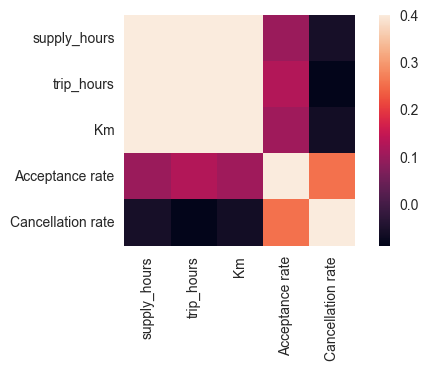

In [509]:
#correlation matrix
fig = plt.figure(figsize= (20,5))

fig.suptitle("Data Correlation", fontsize=20)
corrmat = UUID_merged2.corr()
f, ax = plt.subplots(figsize=(6, 3))
sns.heatmap(corrmat, vmax=.4, square=True);

In [ ]:
#Spearman Correlation
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['Gross Earnings'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')

features = quantitative 
spearman(UUID_merged_update2, features)

Data Distribution

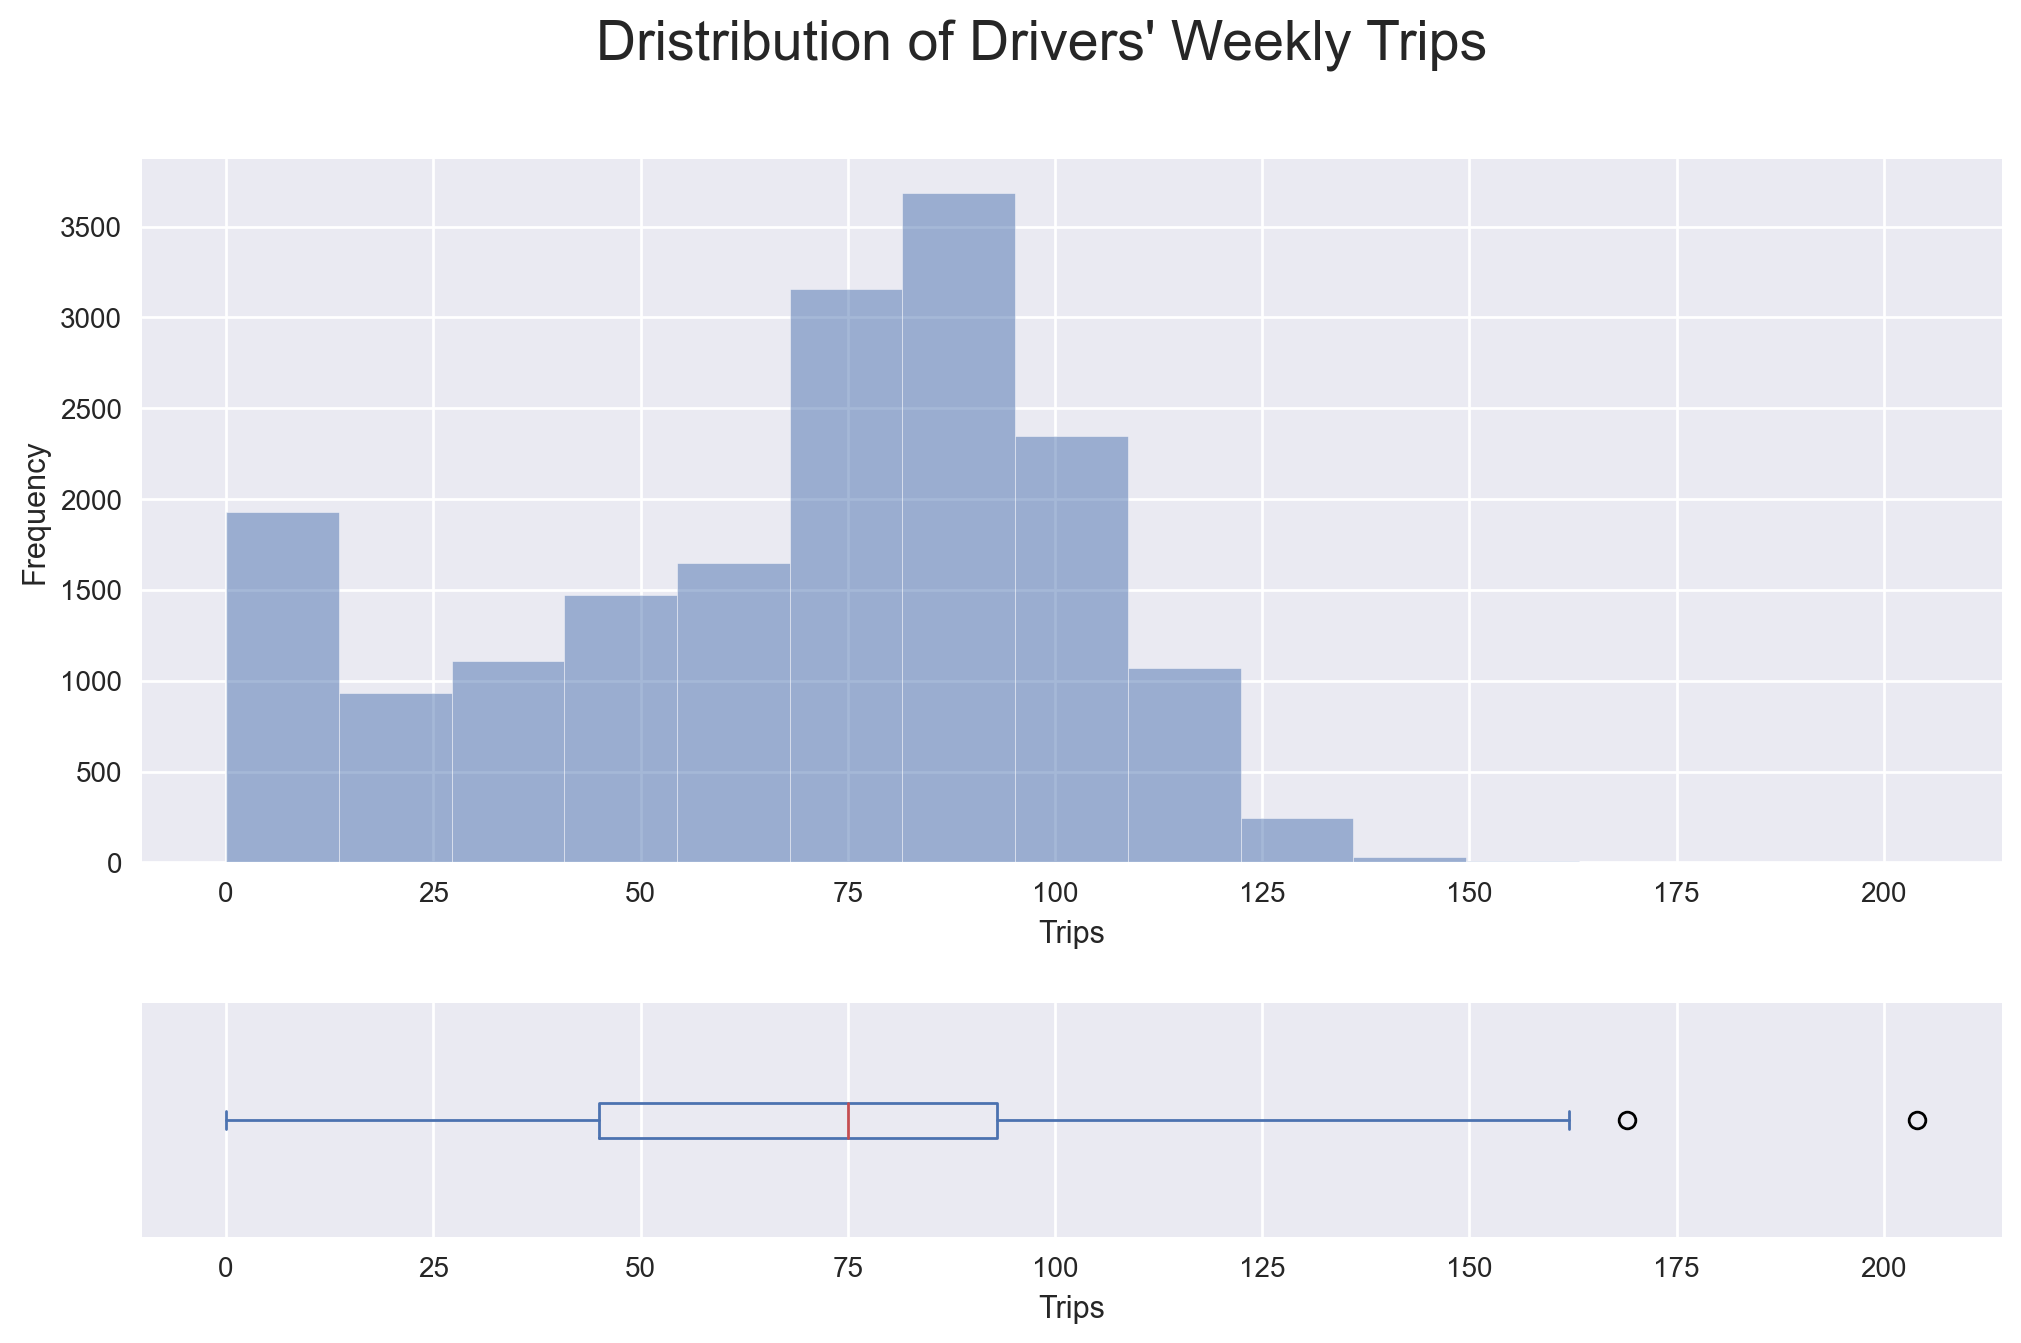

Sample size of >> 1074 drivers
No. weeks observed >> 85 weeks (2021-03-22 00:00:00 - 2022-10-31 00:00:00)
Average weekly Trips per driver >> 67.50 Trips
Median weekly Trips per driver >> 75.00 Trips
weekly standard deviation of Trips per driver >> 33.91 


In [510]:
fig, ax = plt.subplots(2,figsize=(12,7), gridspec_kw={'height_ratios': [3, 1]}, dpi=200)

UUID_merged_update2['Trips'].plot(
    kind="hist", 
    bins=15,
    alpha=0.5, #adjusts the transperancy
    ax=ax[0],
)
UUID_merged_update2['Trips'].plot(
    kind="box",
    vert=False, #makes the box plot horizontal
    ax=ax[1],
)
fig.suptitle("Dristribution of Drivers' Weekly Trips", fontsize=20)
for i in range(len(ax)):
    ax[i].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax[i].set_xlabel("Trips")
ax[1].axes.get_yaxis().set_visible(False)
plt.subplots_adjust(hspace=0.3)
plt.show()

print("Sample size of >>", UUID_merged_update2["DRN"].nunique(), "drivers")
print("No. weeks observed >>", UUID_merged_update2['week_date'].nunique(), "weeks (" + str(UUID_merged_update2['week_date'].min()), "-", str(UUID_merged_update2['week_date'].max())+")")
print("Average weekly Trips per driver >>", "{:0,.2f}".format(UUID_merged_update2["Trips"].mean().round(2)), "Trips") 
print("Median weekly Trips per driver >>", "{:0,.2f}".format(UUID_merged_update2["Trips"].median().round(2)), "Trips")
print("weekly standard deviation of Trips per driver >>", "{:0,.2f}".format(UUID_merged_update2["Trips"].std().round(2)),"")

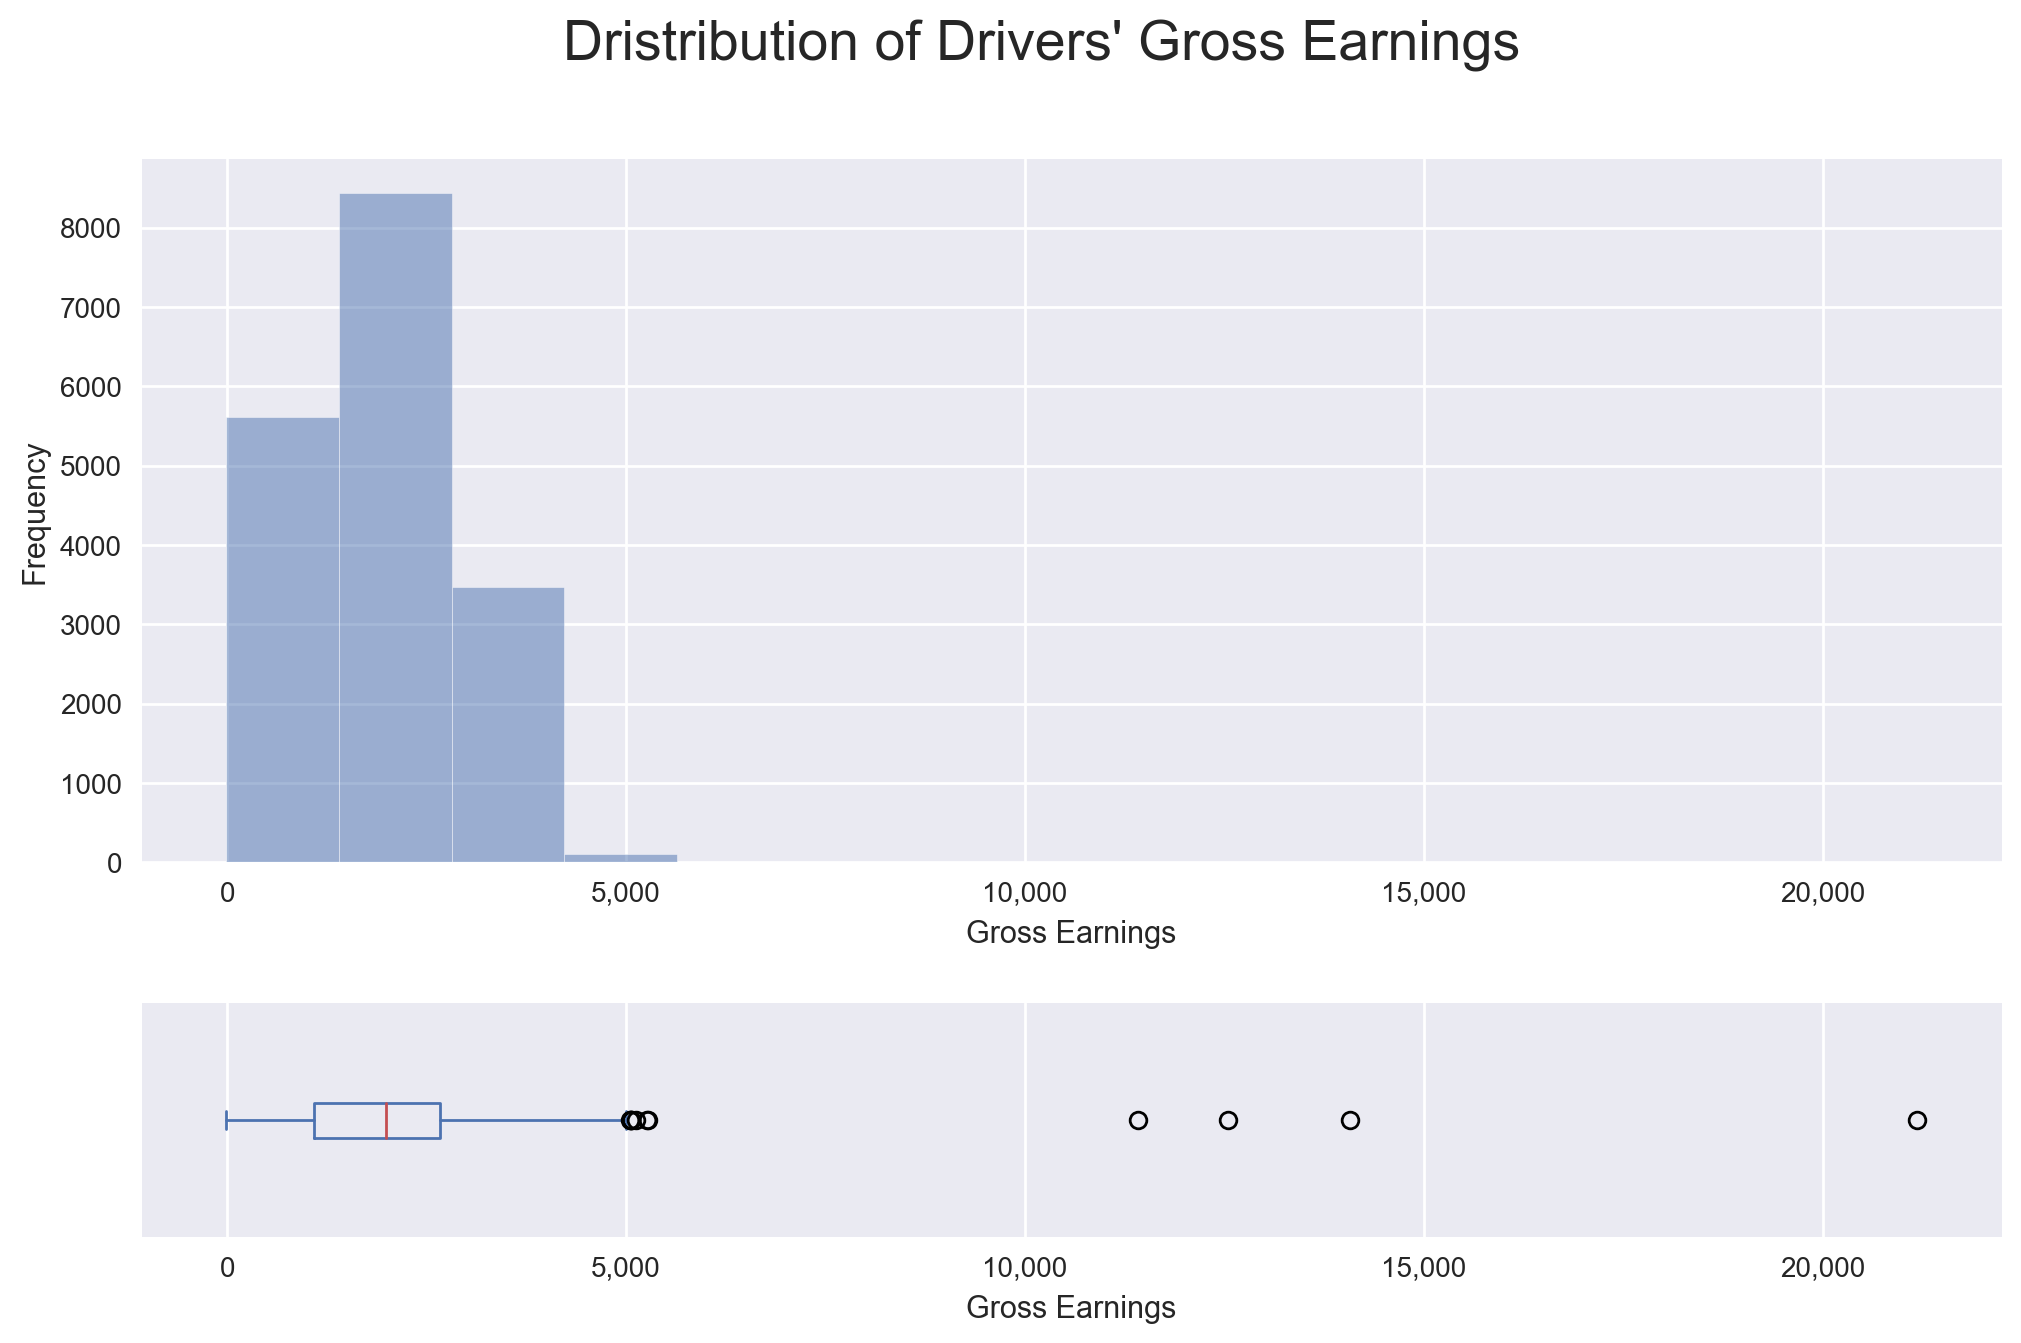

Sample size of >> 1075 drivers
No. weeks observed >> 85 weeks (2021-03-22 00:00:00 - 2022-10-31 00:00:00)
Average weekly Trips per driver >> 1,884.28 GH₵
Median weekly Trips per driver >> 1,988.67 GH₵
weekly standard deviation of Trips per driver >> 1,081.40 


In [511]:
fig, ax = plt.subplots(2,figsize=(12,7), gridspec_kw={'height_ratios': [3, 1]}, dpi=200)
UUID_merged_update2['Gross Earnings'].plot(
    kind="hist", 
    bins=15,
    alpha=0.5, #adjusts the transperancy
    ax=ax[0],
)
UUID_merged_update2['Gross Earnings'].plot(
    kind="box",
    vert=False, #makes the box plot horizontal
    ax=ax[1],
)
fig.suptitle("Dristribution of Drivers' Gross Earnings", fontsize=20)
for i in range(len(ax)):
    ax[i].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax[i].set_xlabel("Gross Earnings")
ax[1].axes.get_yaxis().set_visible(False)
plt.subplots_adjust(hspace=0.3)
plt.show()


print("Sample size of >>", UUID_merged_update2["driveruuid"].nunique(), "drivers")
print("No. weeks observed >>", UUID_merged_update2['week_date'].nunique(), "weeks (" + str(UUID_merged_update2['week_date'].min()), "-", str(UUID_merged_update2['week_date'].max())+")")
print("Average weekly Trips per driver >>", "{:0,.2f}".format(UUID_merged_update2["Gross Earnings"].mean().round(2)), "GH₵") 
print("Median weekly Trips per driver >>", "{:0,.2f}".format(UUID_merged_update2["Gross Earnings"].median().round(2)), "GH₵")
print("weekly standard deviation of Trips per driver >>", "{:0,.2f}".format(UUID_merged_update2["Gross Earnings"].std().round(2)),"")

In [ ]:
#filter the data for a proper distribution fit
filtered = UUID_merged_update2['Gross Earnings'][UUID_merged_update2['Gross Earnings'] <= 5000 ]
#filtered.max()

In [ ]:
fig, ax = plt.subplots(2,figsize=(12,7), gridspec_kw={'height_ratios': [3, 1]}, dpi=200)
filtered.plot(
    kind="hist", 
    bins=15,
    alpha=0.5, #adjusts the transperancy
    ax=ax[0],
)
filtered.plot(
    kind="box",
    vert=False, #makes the box plot horizontal
    ax=ax[1],
)
fig.suptitle("Dristribution of Drivers' Gross Earnings", fontsize=20)
for i in range(len(ax)):
    ax[i].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax[i].set_xlabel("Gross Earnings")
ax[1].axes.get_yaxis().set_visible(False)
plt.subplots_adjust(hspace=0.3)
plt.show()

print("Sample size of >>", UUID_merged_update2["driveruuid"].nunique(), "drivers")
print("No. weeks observed >>", UUID_merged_update2['week_date'].nunique(), "weeks (" + str(UUID_merged_update2['week_date'].min()), "-", str(UUID_merged_update2['week_date'].max())+")")
print("Average weekly Trips per driver >>", "{:0,.2f}".format(UUID_merged_update2["Gross Earnings"].mean().round(2)), "GH₵") 
print("Median weekly Trips per driver >>", "{:0,.2f}".format(UUID_merged_update2["Gross Earnings"].median().round(2)), "GH₵")
print("weekly standard deviation of Trips per driver >>", "{:0,.2f}".format(UUID_merged_update2["Gross Earnings"].std().round(2)),"")

In [ ]:
fig, ax = plt.subplots(2,figsize=(12,7), gridspec_kw={'height_ratios': [3, 1]}, dpi=200)

UUID_merged_update2['Amount Due'].plot(
    kind="hist", 
    bins=15,
    alpha=0.5, #adjusts the transperancy
    ax=ax[0],
)
UUID_merged_update2['Amount Due'].plot(
    kind="box",
    vert=False, #makes the box plot horizontal
    ax=ax[1],
)
fig.suptitle("Dristribution of Drivers' Amount Due Weekly", fontsize=20)
for i in range(len(ax)):
    ax[i].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax[i].set_xlabel("Amount Due")
ax[1].axes.get_yaxis().set_visible(False)
plt.subplots_adjust(hspace=0.3)
plt.show()

print("Sample size of >>", UUID_merged_update2['driveruuid'].nunique(), "drivers")
print("No. weeks observed >>", UUID_merged_update2['week_date'].nunique(), "weeks (" + str(UUID_merged_update2['week_date'].min()), "-", str(UUID_merged_update2['week_date'].max())+")")
print("Average weekly Amount Due per driver >>", "{:0,.2f}".format(UUID_merged_update2['Amount Due'].mean().round(2)), "GH₵") 
print("Median weekly Amount Due per driver >>", "{:0,.2f}".format(UUID_merged_update2['Amount Due'].median().round(2)), "GH₵")
print("weekly standard deviation Amount Due per driver >>", "{:0,.2f}".format(UUID_merged_update2['Amount Due'].std().round(2)), "")

In [513]:
#filtered to fit more
filtered_Amount_Due = UUID_merged_update2['Amount Due'].loc[(UUID_merged_update2['Amount Due'] <= 20000) & (UUID_merged_update2['Amount Due'] >= -5000)]
#filtered.max()

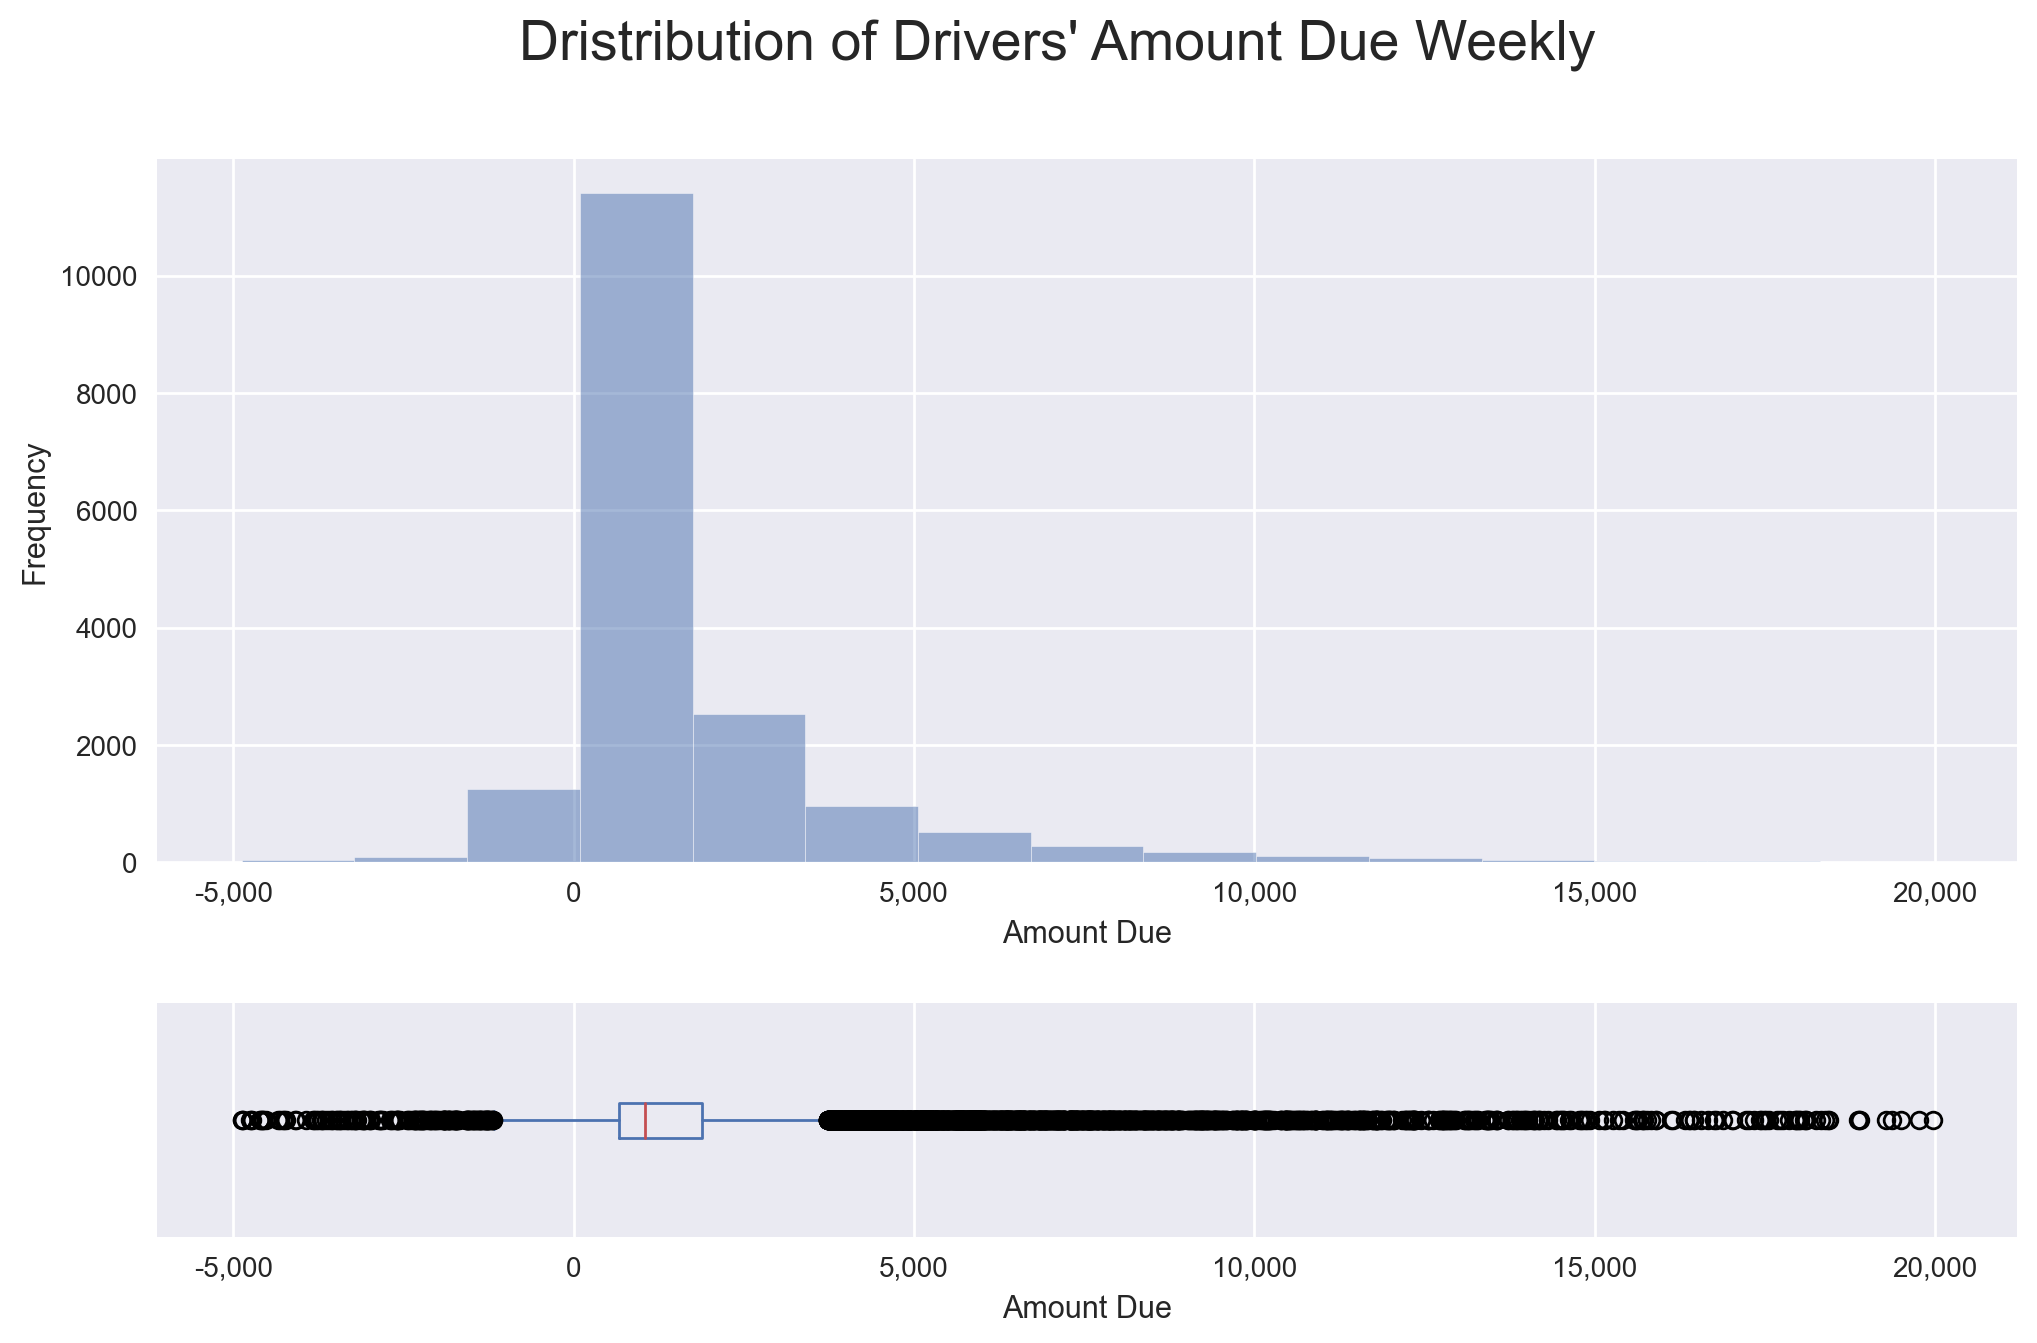

Sample size of >> 1075 drivers
No. weeks observed >> 85 weeks (2021-03-22 00:00:00 - 2022-10-31 00:00:00)
Average weekly Amount Due per driver >> 1,744.59 GH₵
Median weekly Amount Due per driver >> 1,050.75 GH₵
weekly standard deviation Amount Due per driver >> 2,670.93 


In [514]:
fig, ax = plt.subplots(2,figsize=(12,7), gridspec_kw={'height_ratios': [3, 1]}, dpi=200)

filtered_Amount_Due.plot(
    kind="hist", 
    bins=15,
    alpha=0.5, #adjusts the transperancy
    ax=ax[0],
)
filtered_Amount_Due.plot(
    kind="box",
    vert=False, #makes the box plot horizontal
    ax=ax[1],
)
fig.suptitle("Dristribution of Drivers' Amount Due Weekly", fontsize=20)
for i in range(len(ax)):
    ax[i].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax[i].set_xlabel("Amount Due")
ax[1].axes.get_yaxis().set_visible(False)
plt.subplots_adjust(hspace=0.3)
plt.show()

print("Sample size of >>", UUID_merged_update2["driveruuid"].nunique(), "drivers")
print("No. weeks observed >>", UUID_merged_update2['week_date'].nunique(), "weeks (" + str(UUID_merged_update2['week_date'].min()), "-", str(UUID_merged_update2['week_date'].max())+")")
print("Average weekly Amount Due per driver >>", "{:0,.2f}".format(UUID_merged_update2['Amount Due'].mean().round(2)), "GH₵") 
print("Median weekly Amount Due per driver >>", "{:0,.2f}".format(UUID_merged_update2['Amount Due'].median().round(2)), "GH₵")
print("weekly standard deviation Amount Due per driver >>", "{:0,.2f}".format(UUID_merged_update2['Amount Due'].std().round(2)), "")

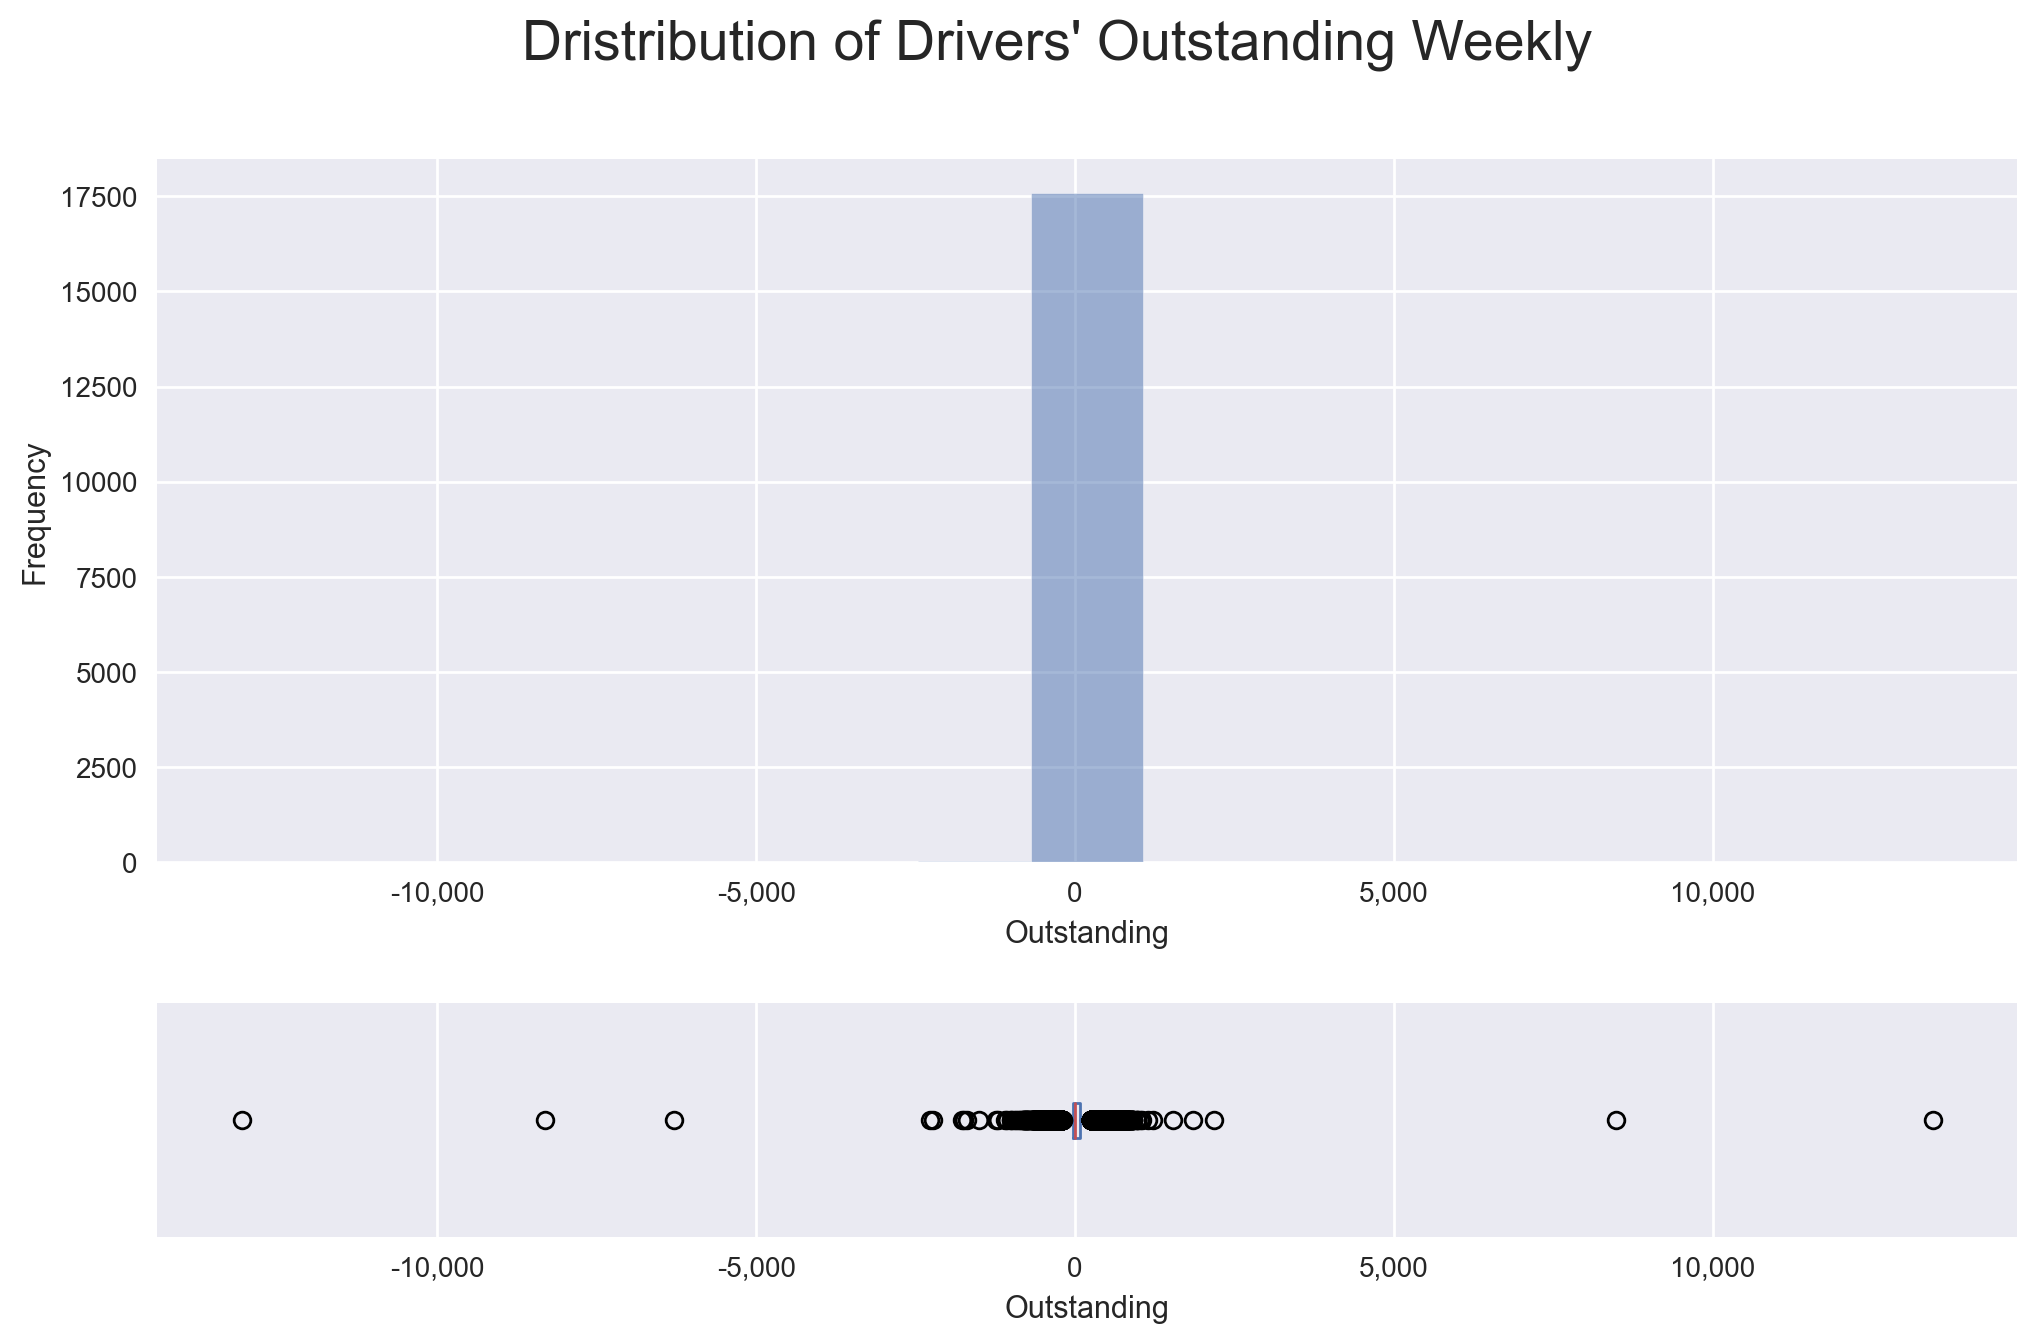

Sample size of >> 1075 drivers
No. weeks observed >> 85 weeks (2021-03-22 00:00:00 - 2022-10-31 00:00:00)
Average weekly Amount Due per driver >> 34.69 GH₵
Median weekly Amount Due per driver >> 0.05 GH₵
weekly standard deviation Amount Due per driver >> 258.22 


In [515]:
fig, ax = plt.subplots(2,figsize=(12,7), gridspec_kw={'height_ratios': [3, 1]}, dpi=200)

UUID_merged_update2['Outstanding'].plot(
    kind="hist", 
    bins=15,
    alpha=0.5, #adjusts the transperancy
    ax=ax[0],
)
UUID_merged_update2['Outstanding'].plot(
    kind="box",
    vert=False, #makes the box plot horizontal
    ax=ax[1],
)
fig.suptitle("Dristribution of Drivers' Outstanding Weekly", fontsize=20)
for i in range(len(ax)):
    ax[i].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax[i].set_xlabel("Outstanding")
ax[1].axes.get_yaxis().set_visible(False)
plt.subplots_adjust(hspace=0.3)
plt.show()

print("Sample size of >>", UUID_merged_update2['driveruuid'].nunique(), "drivers")
print("No. weeks observed >>", UUID_merged_update2['week_date'].nunique(), "weeks (" + str(UUID_merged_update2['week_date'].min()), "-", str(UUID_merged_update2['week_date'].max())+")")
print("Average weekly Amount Due per driver >>", "{:0,.2f}".format(UUID_merged_update2['Outstanding'].mean().round(2)), "GH₵") 
print("Median weekly Amount Due per driver >>", "{:0,.2f}".format(UUID_merged_update2['Outstanding'].median().round(2)), "GH₵")
print("weekly standard deviation Amount Due per driver >>", "{:0,.2f}".format(UUID_merged_update2['Outstanding'].std().round(2)), "")

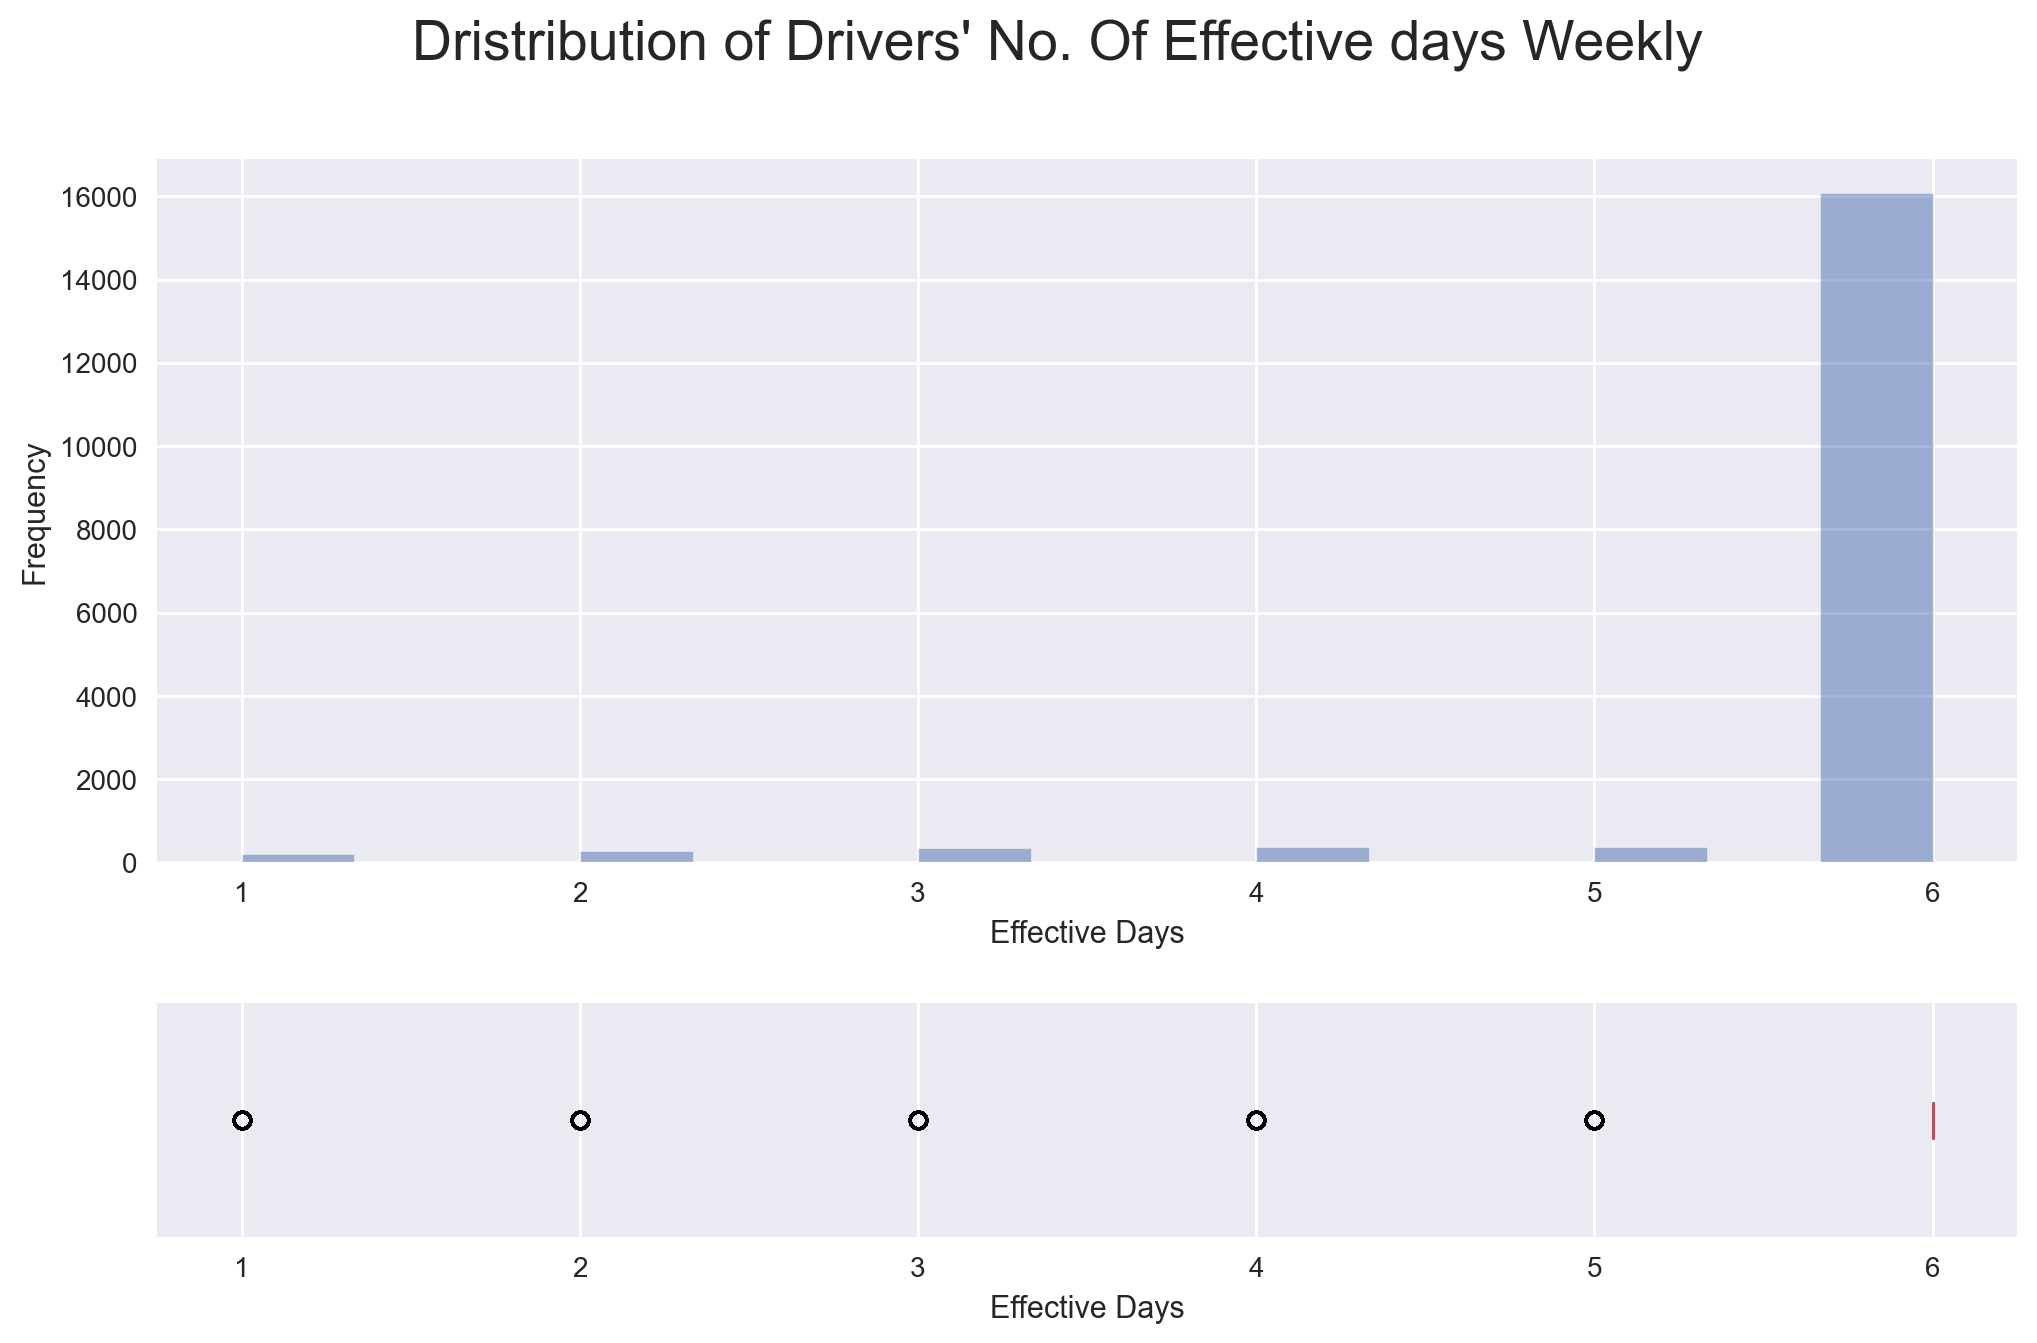

Sample size of >> 1075 drivers
No. weeks observed >> 85 weeks (2021-03-22 00:00:00 - 2022-10-31 00:00:00)
Average weekly Amount Due per driver >> 5.76 
Median weekly Amount Due per driver >> 6.00 
weekly standard deviation Amount Due per driver >> 0.87 


In [516]:
fig, ax = plt.subplots(2,figsize=(12,7), gridspec_kw={'height_ratios': [3, 1]}, dpi=200)

UUID_merged_update2['Effective days'].plot(
    kind="hist", 
    bins=15,
    alpha=0.5, #adjusts the transperancy
    ax=ax[0],
)
UUID_merged_update2['Effective days'].plot(
    kind="box",
    vert=False, #makes the box plot horizontal
    ax=ax[1],
)
fig.suptitle("Dristribution of Drivers' No. Of Effective days Weekly", fontsize=20)
for i in range(len(ax)):
    ax[i].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax[i].set_xlabel("Effective Days")
ax[1].axes.get_yaxis().set_visible(False)
plt.subplots_adjust(hspace=0.3)
plt.show()

print("Sample size of >>", UUID_merged_update2["driveruuid"].nunique(), "drivers")
print("No. weeks observed >>", UUID_merged_update2['week_date'].nunique(), "weeks (" + str(UUID_merged_update2['week_date'].min()), "-", str(UUID_merged_update2['week_date'].max())+")")
print("Average weekly Amount Due per driver >>", "{:0,.2f}".format(UUID_merged_update2['Effective days'].mean().round(2)), "") 
print("Median weekly Amount Due per driver >>", "{:0,.2f}".format(UUID_merged_update2['Effective days'].median().round(2)), "")
print("weekly standard deviation Amount Due per driver >>", "{:0,.2f}".format(UUID_merged_update2['Effective days'].std().round(2)), "")

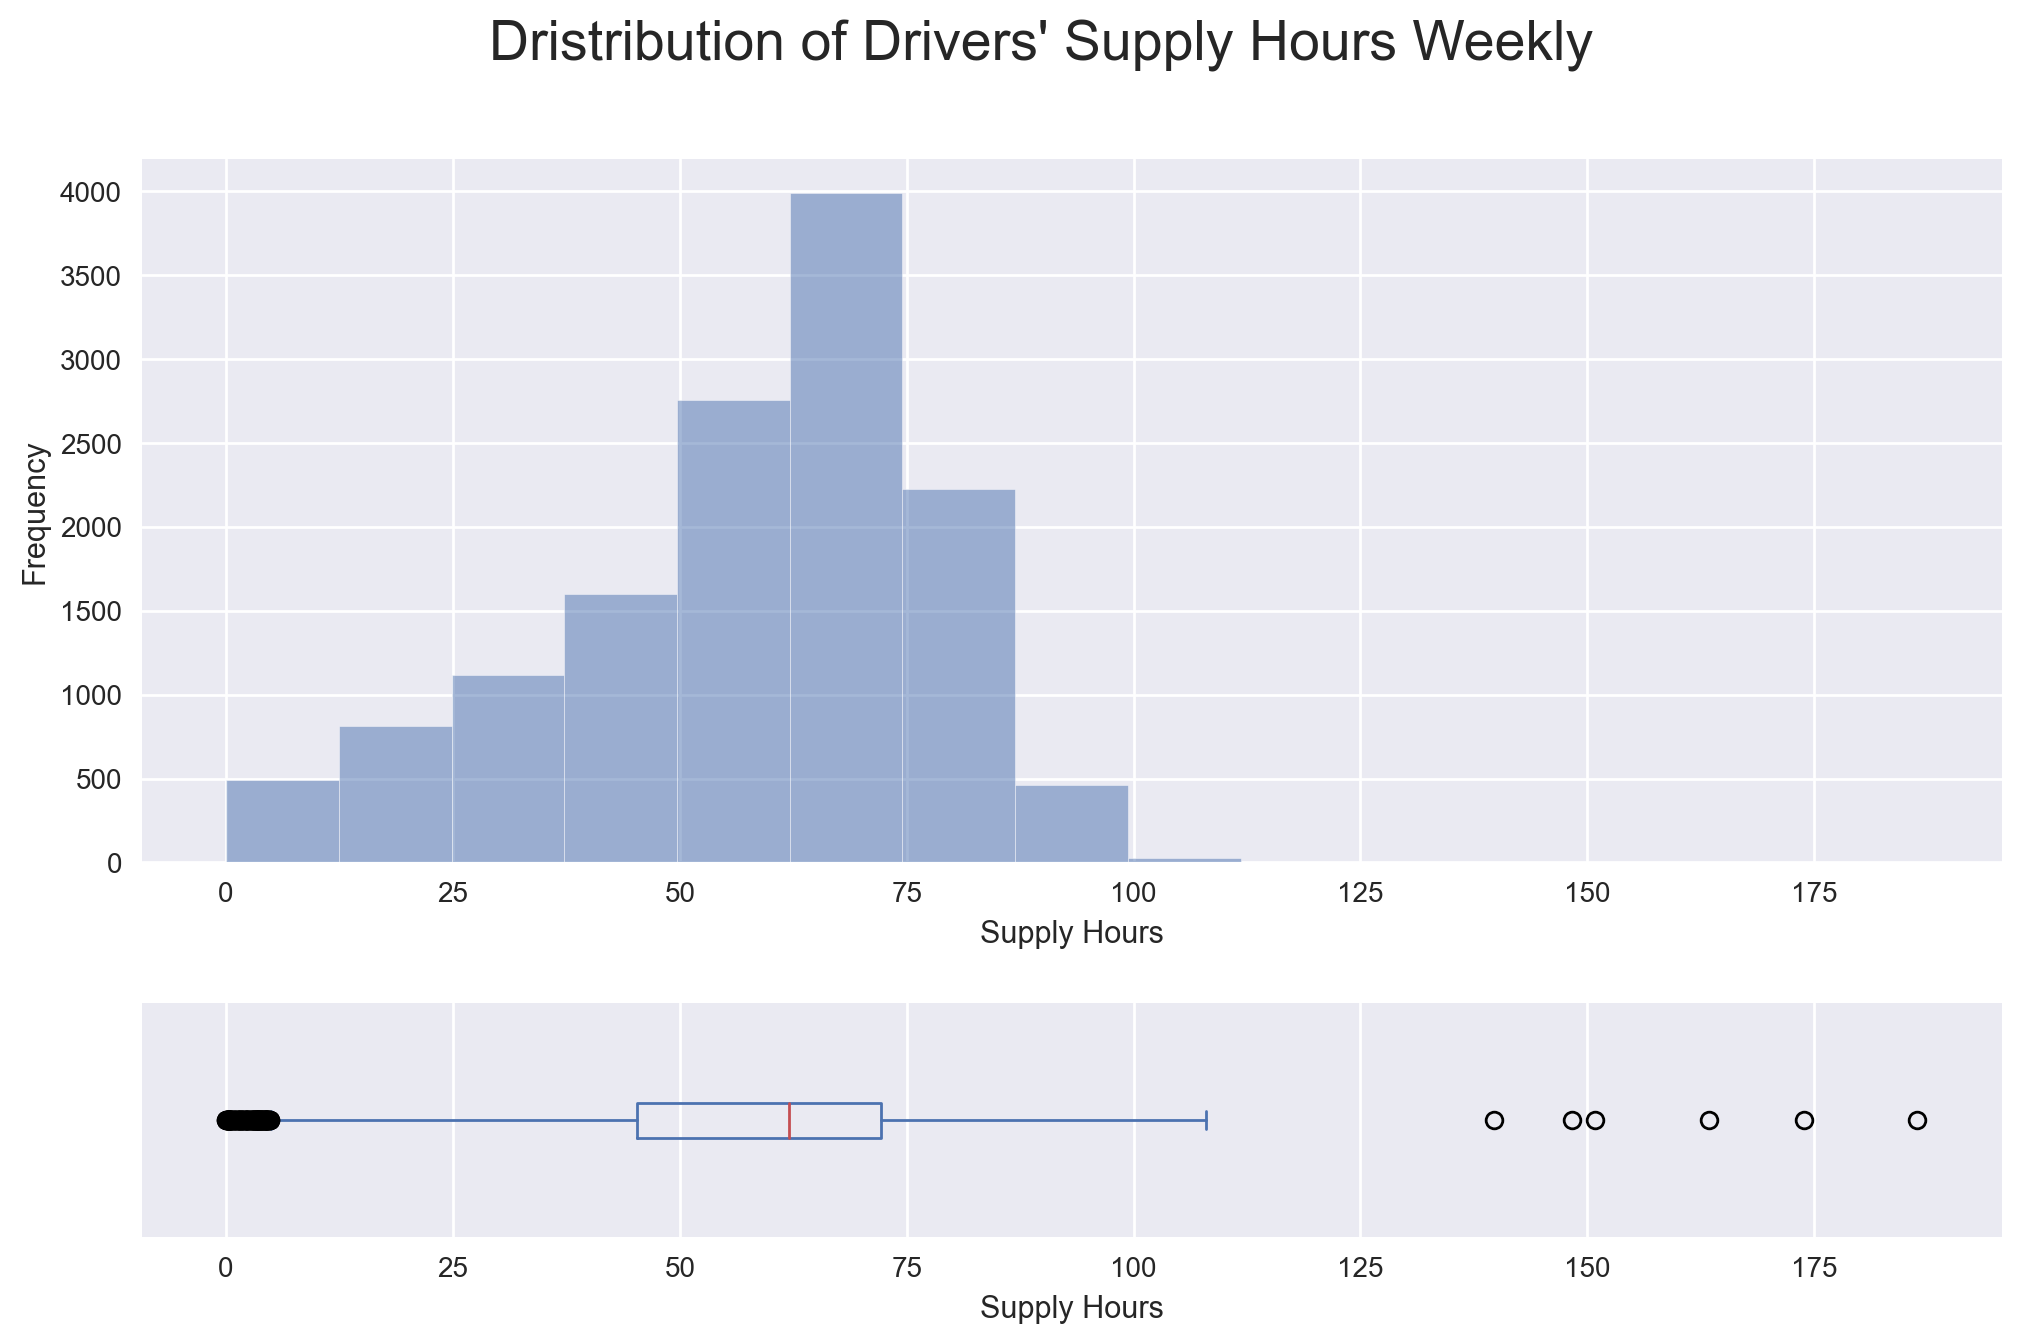

Sample size of >> 1075 drivers
No. weeks observed >> 85 weeks (2021-03-22 00:00:00 - 2022-10-31 00:00:00)
Average weekly Amount Due per driver >> 57.55 
Median weekly Amount Due per driver >> 62.00 
weekly standard deviation Amount Due per driver >> 20.86 


In [517]:
fig, ax = plt.subplots(2,figsize=(12,7), gridspec_kw={'height_ratios': [3, 1]}, dpi=200)

UUID_merged_update2['supply_hours'].plot(
    kind="hist", 
    bins=15,
    alpha=0.5, #adjusts the transperancy
    ax=ax[0],
)
UUID_merged_update2['supply_hours'].plot(
    kind="box",
    vert=False, #makes the box plot horizontal
    ax=ax[1],
)
fig.suptitle("Dristribution of Drivers' Supply Hours Weekly", fontsize=20)
for i in range(len(ax)):
    ax[i].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax[i].set_xlabel("Supply Hours")
ax[1].axes.get_yaxis().set_visible(False)
plt.subplots_adjust(hspace=0.3)
plt.show()

print("Sample size of >>", UUID_merged_update2["driveruuid"].nunique(), "drivers")
print("No. weeks observed >>", UUID_merged_update2['week_date'].nunique(), "weeks (" + str(UUID_merged_update2['week_date'].min()), "-", str(UUID_merged_update2['week_date'].max())+")")
print("Average weekly Amount Due per driver >>", "{:0,.2f}".format(UUID_merged_update2['supply_hours'].mean().round(2)), "") 
print("Median weekly Amount Due per driver >>", "{:0,.2f}".format(UUID_merged_update2['supply_hours'].median().round(2)), "")
print("weekly standard deviation Amount Due per driver >>", "{:0,.2f}".format(UUID_merged_update2['supply_hours'].std().round(2)), "")

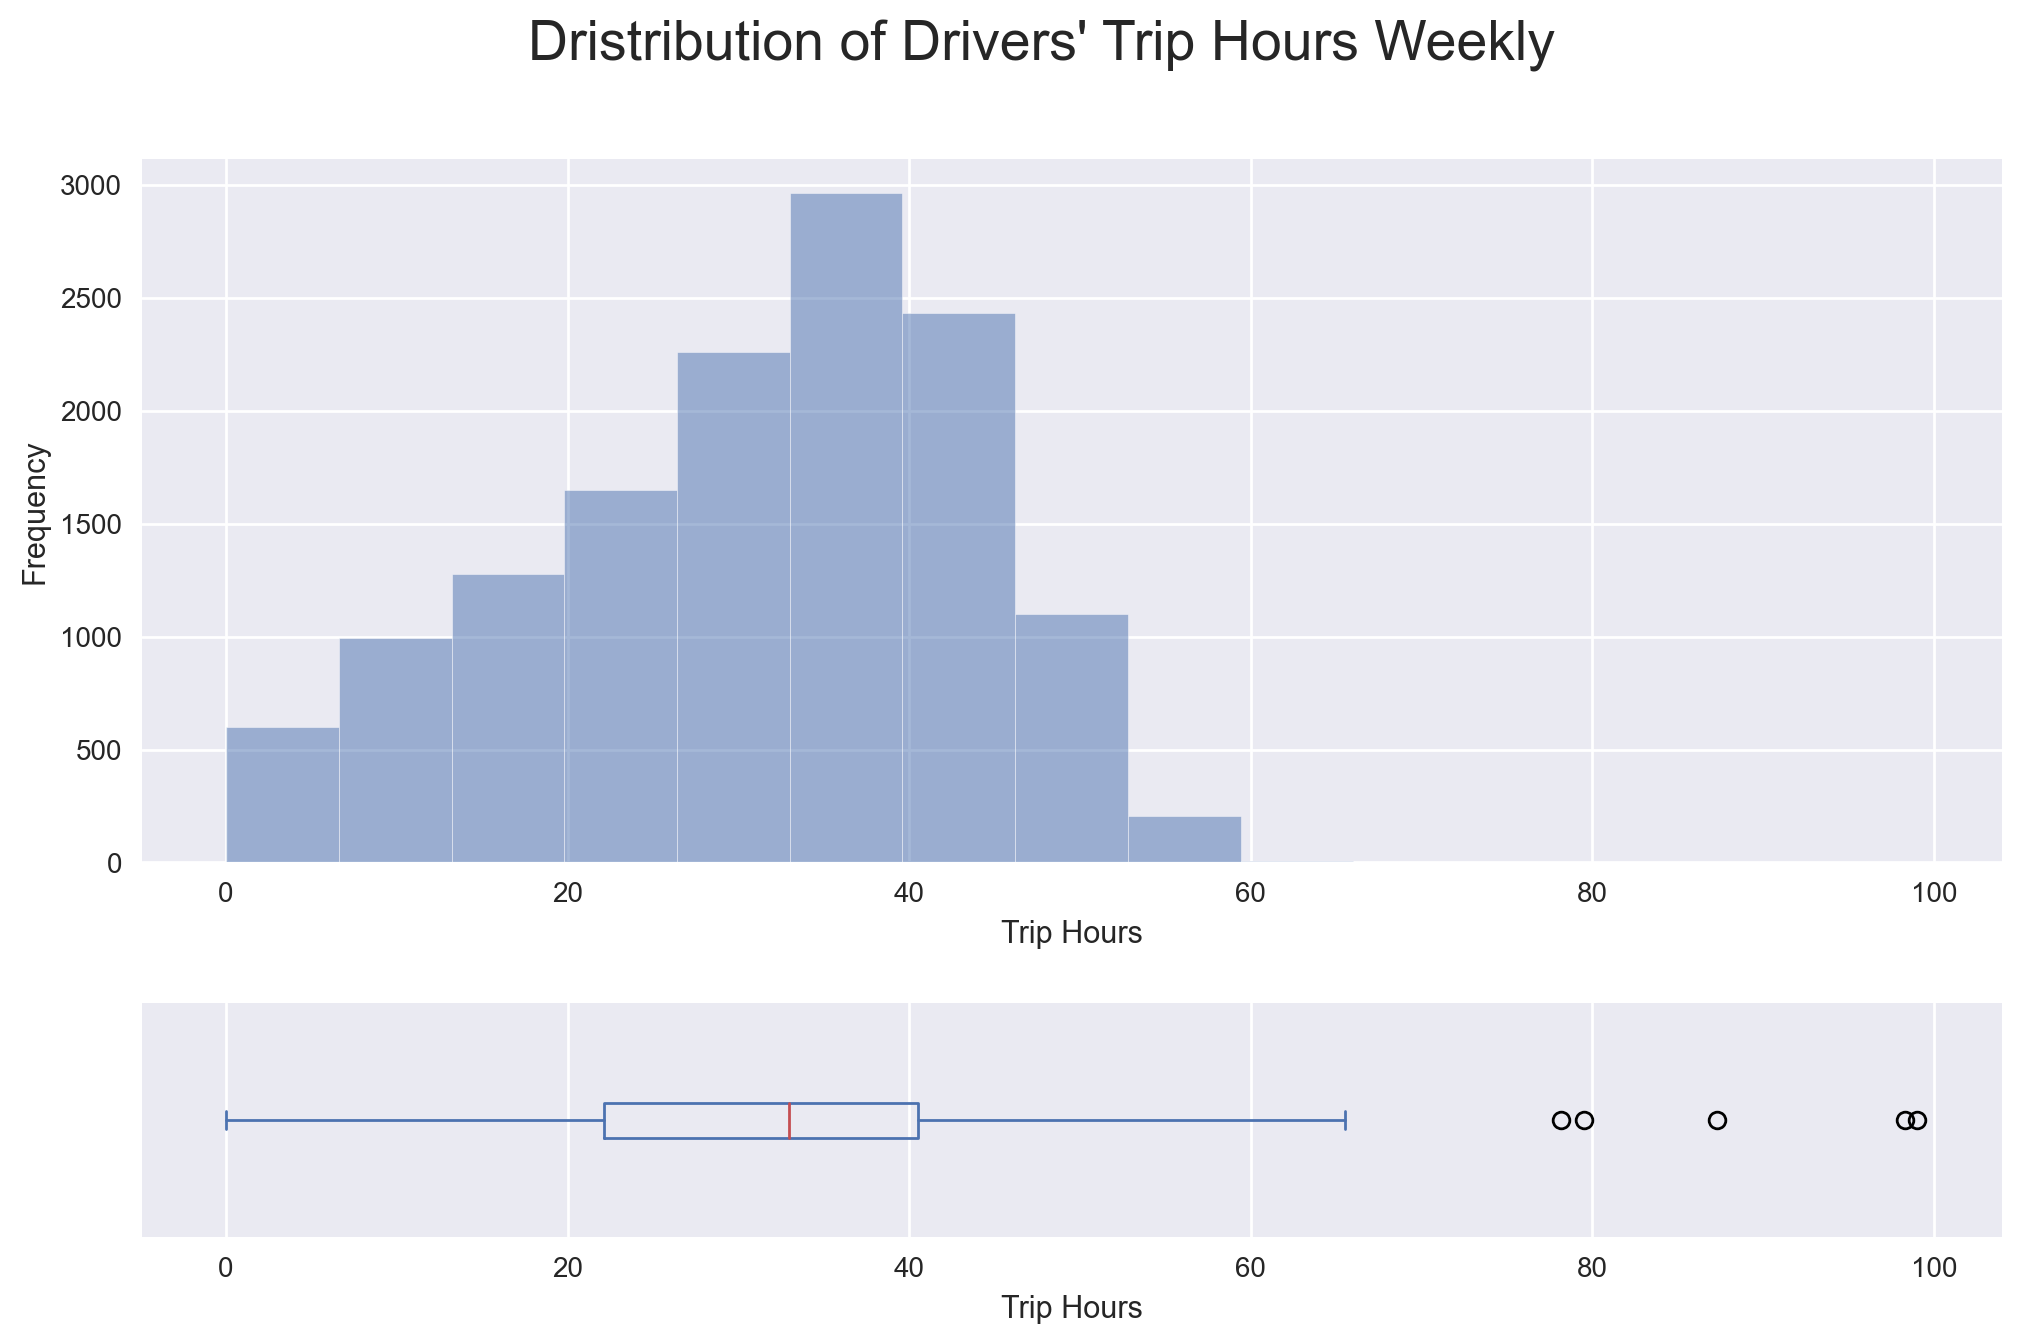

Sample size of >> 1075 drivers
No. weeks observed >> 85 weeks (2021-03-22 00:00:00 - 2022-10-31 00:00:00)
Average weekly Amount Due per driver >> 30.86 Hours
Median weekly Amount Due per driver >> 32.93 Hours
weekly standard deviation Amount Due per driver >> 12.79 Hours


In [518]:
fig, ax = plt.subplots(2,figsize=(12,7), gridspec_kw={'height_ratios': [3, 1]}, dpi=200)

UUID_merged_update2['trip_hours'].plot(
    kind="hist", 
    bins=15,
    alpha=0.5, #adjusts the transperancy
    ax=ax[0],
)
UUID_merged_update2['trip_hours'].plot(
    kind="box",
    vert=False, #makes the box plot horizontal
    ax=ax[1],
)
fig.suptitle("Dristribution of Drivers' Trip Hours Weekly", fontsize=20)
for i in range(len(ax)):
    ax[i].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax[i].set_xlabel("Trip Hours")
ax[1].axes.get_yaxis().set_visible(False)
plt.subplots_adjust(hspace=0.3)
plt.show()

print("Sample size of >>", UUID_merged_update2["driveruuid"].nunique(), "drivers")
print("No. weeks observed >>", UUID_merged_update2['week_date'].nunique(), "weeks (" + str(UUID_merged_update2['week_date'].min()), "-", str(UUID_merged_update2['week_date'].max())+")")
print("Average weekly Amount Due per driver >>", "{:0,.2f}".format(UUID_merged_update2['trip_hours'].mean().round(2)), "Hours") 
print("Median weekly Amount Due per driver >>", "{:0,.2f}".format(UUID_merged_update2['trip_hours'].median().round(2)), "Hours")
print("weekly standard deviation Amount Due per driver >>", "{:0,.2f}".format(UUID_merged_update2['trip_hours'].std().round(2)), "Hours")

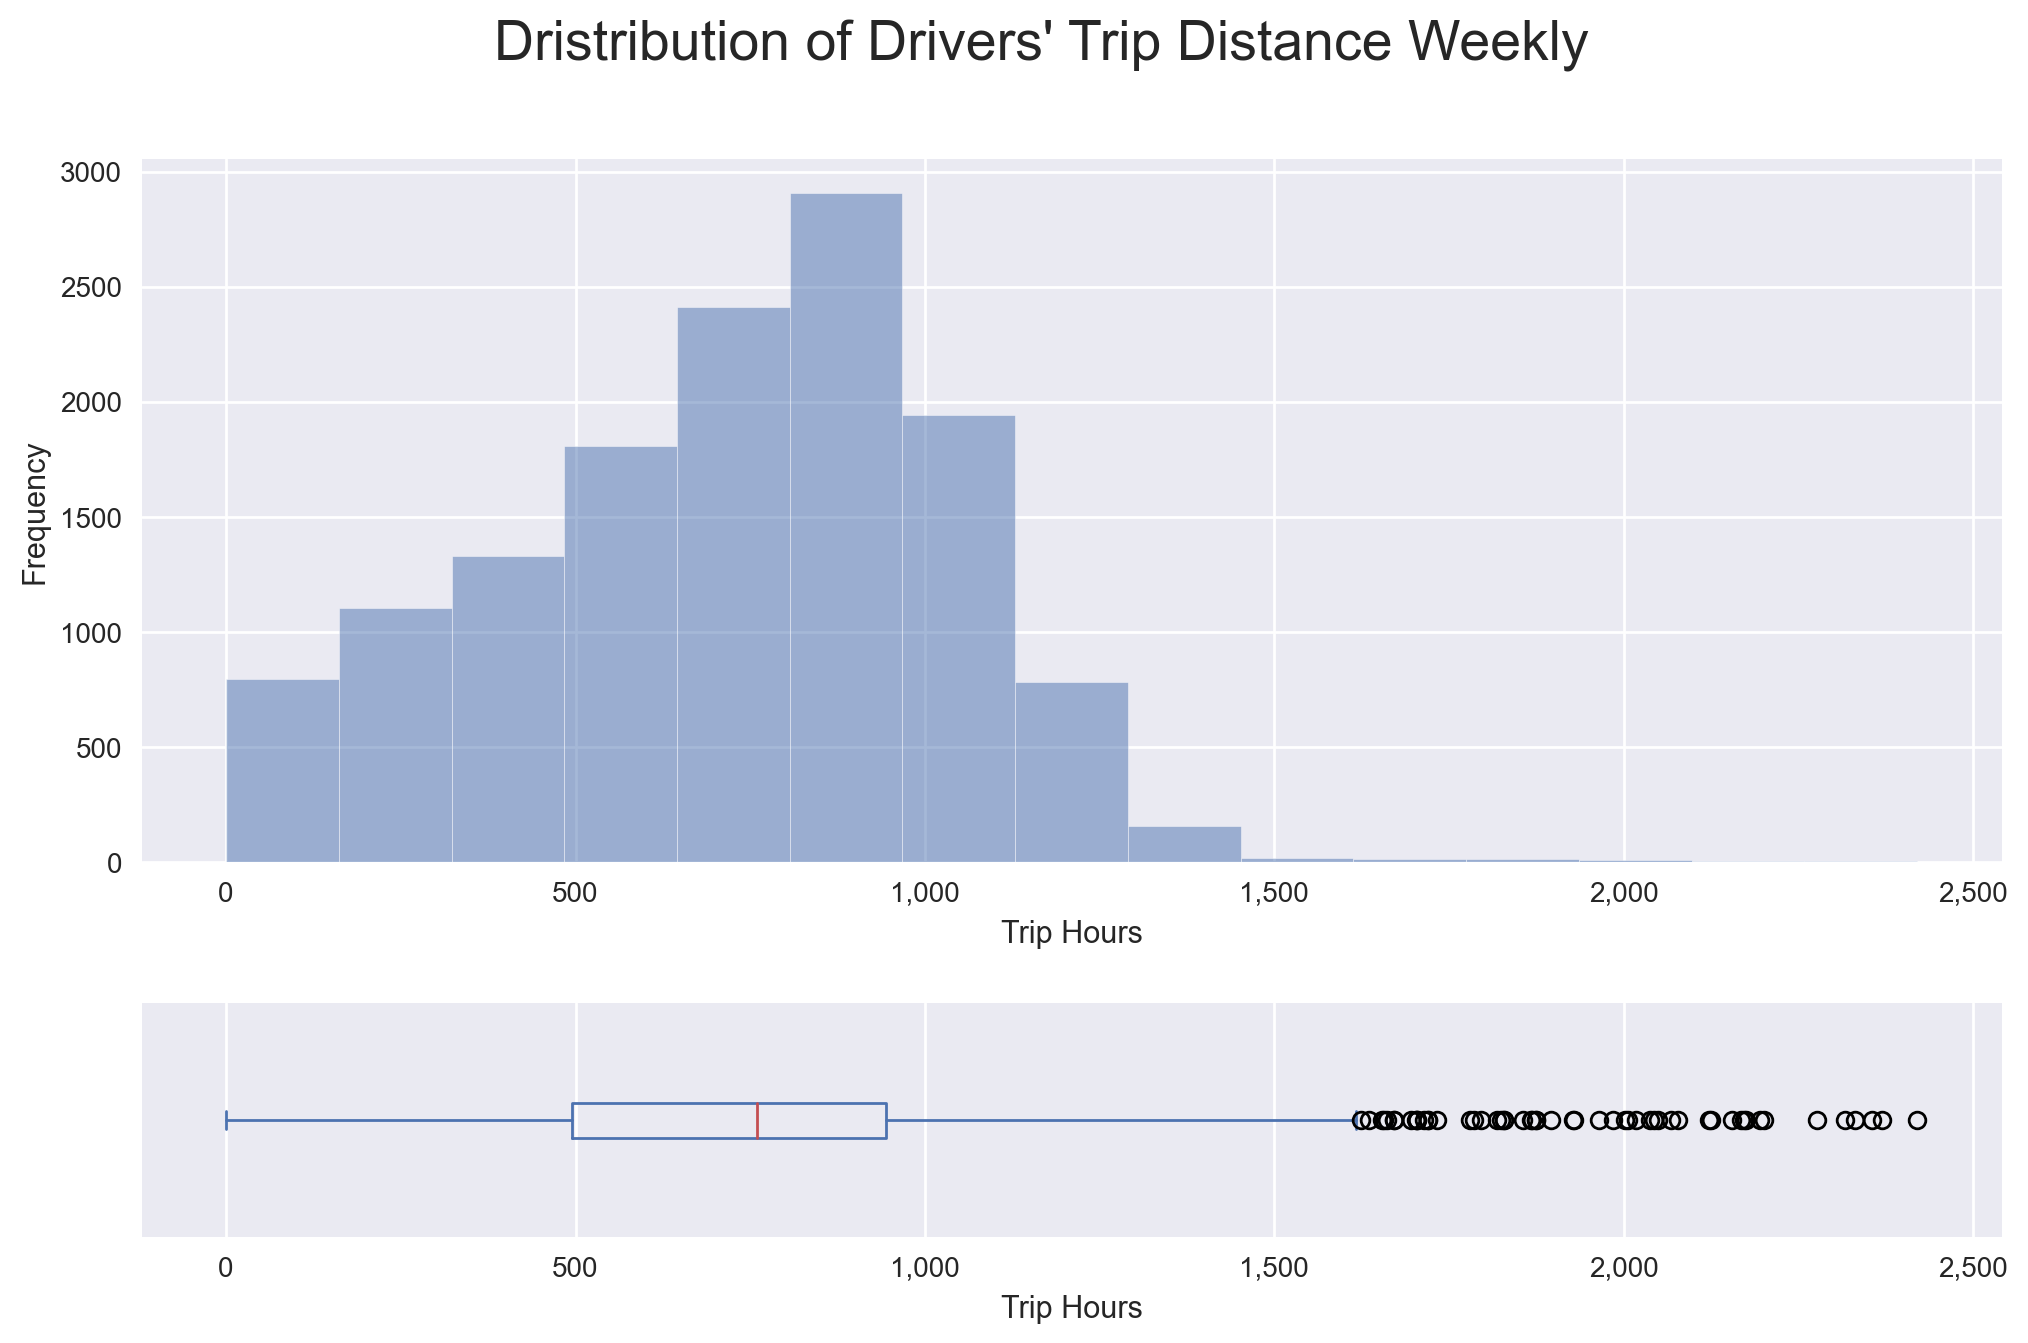

Sample size of >> 1075 drivers
No. weeks observed >> 85 weeks (2021-03-22 00:00:00 - 2022-10-31 00:00:00)
Average weekly Amount Due per driver >> 717.15 Km
Median weekly Amount Due per driver >> 759.66 Km
weekly standard deviation Amount Due per driver >> 322.41 Km


In [519]:
fig, ax = plt.subplots(2,figsize=(12,7), gridspec_kw={'height_ratios': [3, 1]}, dpi=200)

UUID_merged_update2['Km'].plot(
    kind="hist", 
    bins=15,
    alpha=0.5, #adjusts the transperancy
    ax=ax[0],
)
UUID_merged_update2['Km'].plot(
    kind="box",
    vert=False, #makes the box plot horizontal
    ax=ax[1],
)
fig.suptitle("Dristribution of Drivers' Trip Distance Weekly", fontsize=20)
for i in range(len(ax)):
    ax[i].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax[i].set_xlabel("Trip Hours")
ax[1].axes.get_yaxis().set_visible(False)
plt.subplots_adjust(hspace=0.3)
plt.show()

print("Sample size of >>", UUID_merged_update2["driveruuid"].nunique(), "drivers")
print("No. weeks observed >>", UUID_merged_update2['week_date'].nunique(), "weeks (" + str(UUID_merged_update2['week_date'].min()), "-", str(UUID_merged_update2['week_date'].max())+")")
print("Average weekly Amount Due per driver >>", "{:0,.2f}".format(UUID_merged_update2['Km'].mean().round(2)), "Km") 
print("Median weekly Amount Due per driver >>", "{:0,.2f}".format(UUID_merged_update2['Km'].median().round(2)), "Km")
print("weekly standard deviation Amount Due per driver >>", "{:0,.2f}".format(UUID_merged_update2['Km'].std().round(2)), "Km")

In [ ]:
UUID_merged_update2['Acceptance rate'].astype(float)

In [ ]:
fig, ax = plt.subplots(2,figsize=(12,7), gridspec_kw={'height_ratios': [3, 1]}, dpi=200)

UUID_merged_update2['Acceptance rate'].plot(
    kind="hist", 
    bins=15,
    alpha=0.5, #adjusts the transperancy
    ax=ax[0],
)
UUID_merged_update2['Acceptance rate'].plot(
    kind="box",
    vert=False, #makes the box plot horizontal
    ax=ax[1],
)
fig.suptitle("Dristribution of Drivers' Acceptance rateWeekly", fontsize=20)
for i in range(len(ax)):
    ax[i].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax[i].set_xlabel("Acceptance rate")
ax[1].axes.get_yaxis().set_visible(False)
plt.subplots_adjust(hspace=0.3)
plt.show()

print("Sample size of >>", UUID_merged_update2["driveruuid"].nunique(), "drivers")
print("No. weeks observed >>", UUID_merged_update2['week_date'].nunique(), "weeks (" + str(UUID_merged_update2['week_date'].min()), "-", str(UUID_merged_update2['week_date'].max())+")")
print("Average weekly Amount Due per driver >>", "{:0,.2f}".format(UUID_merged_update2['Acceptance rate'].mean().round(2)), "") 
print("Median weekly Amount Due per driver >>", "{:0,.2f}".format(UUID_merged_update2['Acceptance rate'].median().round(2)), "")
print("weekly standard deviation Amount Due per driver >>", "{:0,.2f}".format(UUID_merged_update2['Acceptance rate'].std().round(2)), "")

In [ ]:
fig, ax = plt.subplots(2,figsize=(12,7), gridspec_kw={'height_ratios': [3, 1]}, dpi=200)

UUID_merged_update2['Cancellation rate'].plot(
    kind="hist", 
    bins=15,
    alpha=0.5, #adjusts the transperancy
    ax=ax[0],
)
UUID_merged_update2['Cancellation rate'].plot(
    kind="box",
    vert=False, #makes the box plot horizontal
    ax=ax[1],
)
fig.suptitle("Dristribution of Drivers' Cancellation rate Weekly", fontsize=20)
for i in range(len(ax)):
    ax[i].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax[i].set_xlabel("Trip Hours")
ax[1].axes.get_yaxis().set_visible(False)
plt.subplots_adjust(hspace=0.3)
plt.show()

print("Sample size of >>", UUID_merged_update2["driveruuid"].nunique(), "drivers")
print("No. weeks observed >>", UUID_merged_update2['week_date'].nunique(), "weeks (" + str(UUID_merged_update2['week_date'].min()), "-", str(UUID_merged_update2['week_date'].max())+")")
print("Average weekly Amount Due per driver >>", "{:0,.2f}".format(UUID_merged_update2['Cancellation rate'].mean().round(2)), "") 
print("Median weekly Amount Due per driver >>", "{:0,.2f}".format(UUID_merged_update2['Cancellation rate'].median().round(2)), "")
print("weekly standard deviation Amount Due per driver >>", "{:0,.2f}".format(UUID_merged_update2['Cancellation rate'].std().round(2)), "")

c:\Users\ibrad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


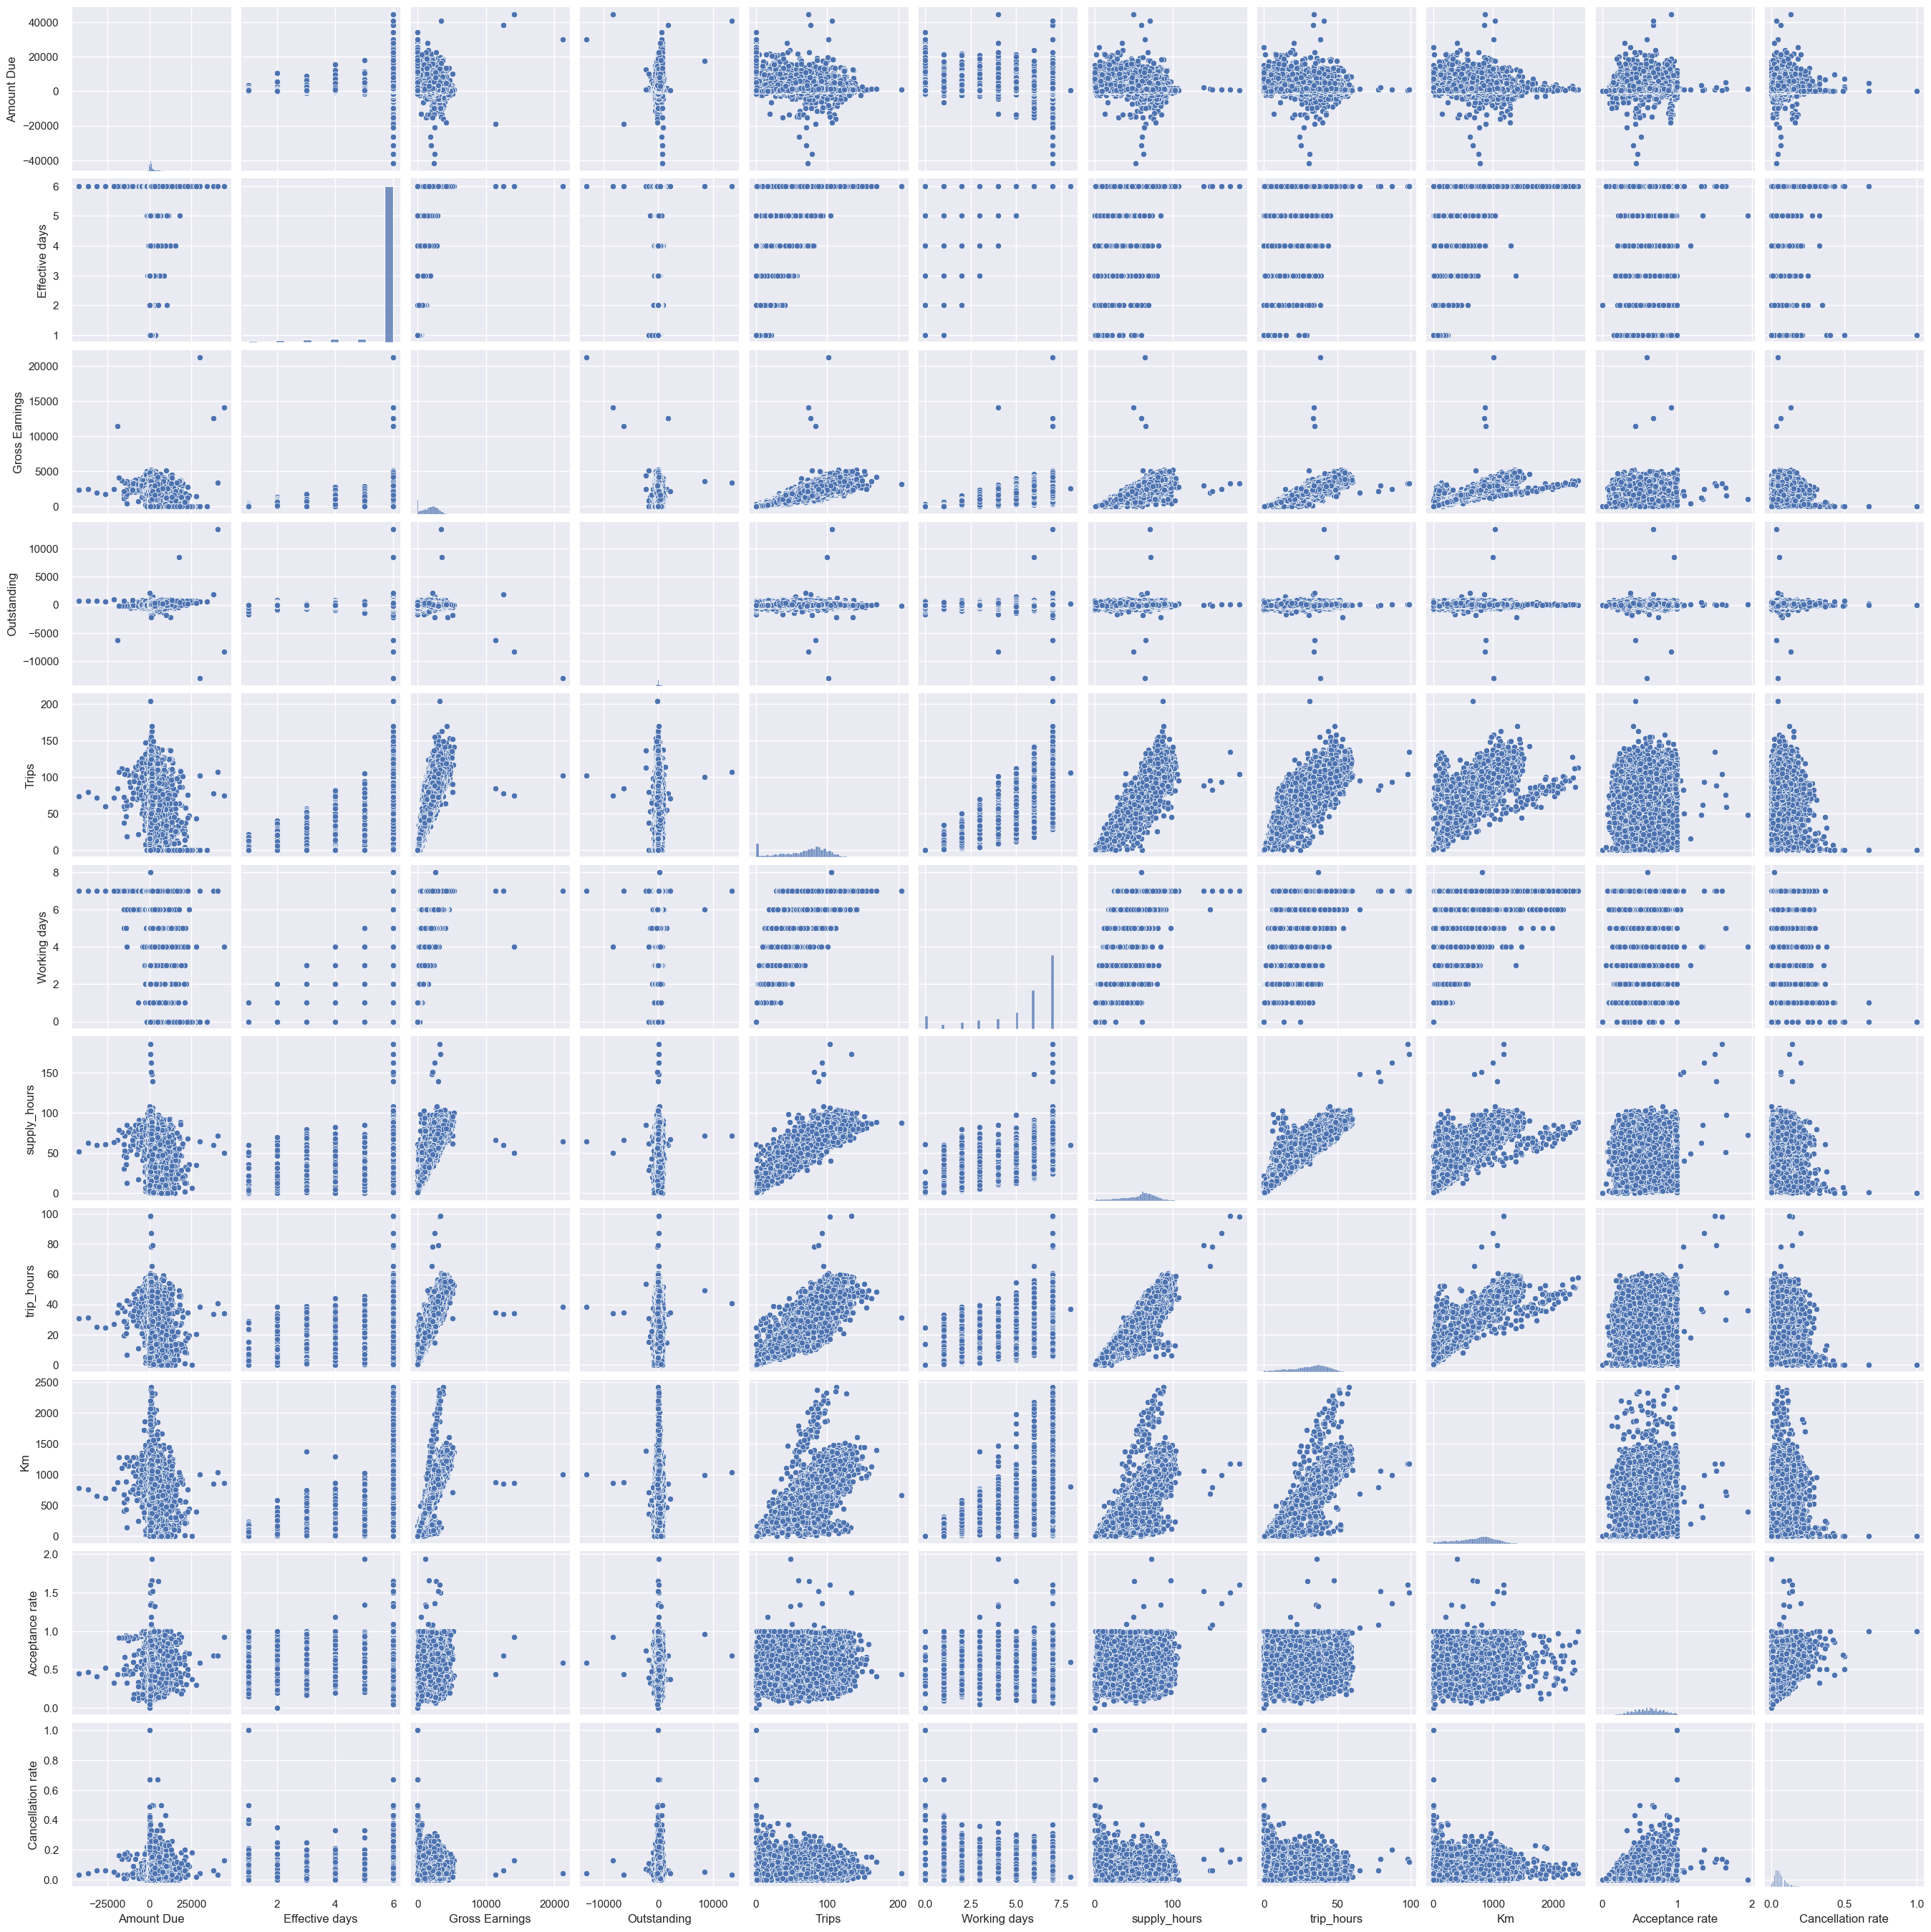

In [521]:
#Pair plot
sns.set() 
cols = ['Amount Due', 'Effective days', 'Gross Earnings', 'Outstanding', 'Trips', 'Working days', 'supply_hours','trip_hours','Km','Acceptance rate','Cancellation rate']
sns.pairplot(UUID_merged_update2[cols], size = 2.5)
plt.show();